In [1]:
import os, sys, glob
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import patches
import lightkurve as lk
from astropy.io import fits
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, match_coordinates_3d

%matplotlib inline
path = os.path.dirname(os.getcwd()) 

sys.path.append('%s/Work/BAERI/ADAP/psfmachine/' % os.environ['HOME'])
from psfmachine import Machine
from psfmachine.utils import get_gaia_sources

#%load_ext autoreload
#%autoreload 2

In [2]:
path

'/Users/jorgemarpa/Work/BAERI/ADAP/EXBA_pathfinder'

In [3]:
exba = fits.open(f'{path}/data/kplr100002209-2010174085026_lpd-targ.fits.gz')

In [4]:
exba.info()

Filename: /Users/jorgemarpa/Work/BAERI/ADAP/EXBA_pathfinder/data/kplr100002209-2010174085026_lpd-targ.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      58   ()      
  1  TARGETTABLES    1 BinTableHDU    287   4634R x 13C   [D, E, J, 540J, 540E, 540E, 540E, 540E, 540E, J, E, E, 300E]   
  2  APERTURE      1 ImageHDU        48   (9, 60)   int32   


In [5]:
tpfs_paths = np.sort(glob.glob(f'{path}/data/*_lpd-targ.fits.gz'))
len(tpfs_paths)

320

In [6]:
tpfs_paths[:4]

array(['/Users/jorgemarpa/Work/BAERI/ADAP/EXBA_pathfinder/data/kplr100002059-2010174085026_lpd-targ.fits.gz',
       '/Users/jorgemarpa/Work/BAERI/ADAP/EXBA_pathfinder/data/kplr100002060-2010174085026_lpd-targ.fits.gz',
       '/Users/jorgemarpa/Work/BAERI/ADAP/EXBA_pathfinder/data/kplr100002061-2010174085026_lpd-targ.fits.gz',
       '/Users/jorgemarpa/Work/BAERI/ADAP/EXBA_pathfinder/data/kplr100002062-2010174085026_lpd-targ.fits.gz'],
      dtype='<U99')

In [7]:
tpfs = lk.TargetPixelFileCollection([lk.KeplerTargetPixelFile(f) for f in tpfs_paths[:4]])

/Users/jorgemarpa/.pyenv/versions/adap/lib/python3.8/site-packages/lightkurve/utils.py:459: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(cax, ax=ax, norm=norm, label=clabel)


<AxesSubplot:title={'center':'Target ID: 100002059, Cadence: 16373'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

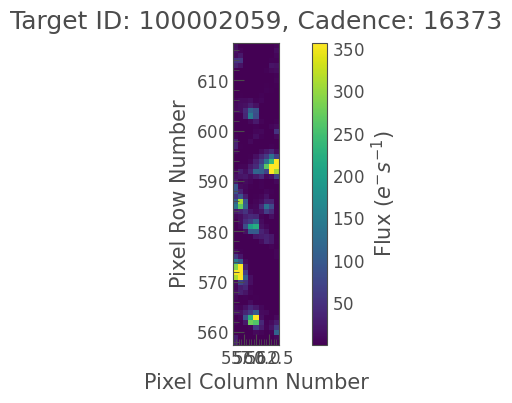

In [8]:
tpfs[0].plot()

In [113]:
channels = [tpf.get_header()['CHANNEL']for tpf in tpfs]
target_ids = [tpf.get_header()['OBJECT']for tpf in tpfs]
ra_objects = [tpf.get_header()['RA_OBJ']for tpf in tpfs]
dec_objects = [tpf.get_header()['DEC_OBJ']for tpf in tpfs]

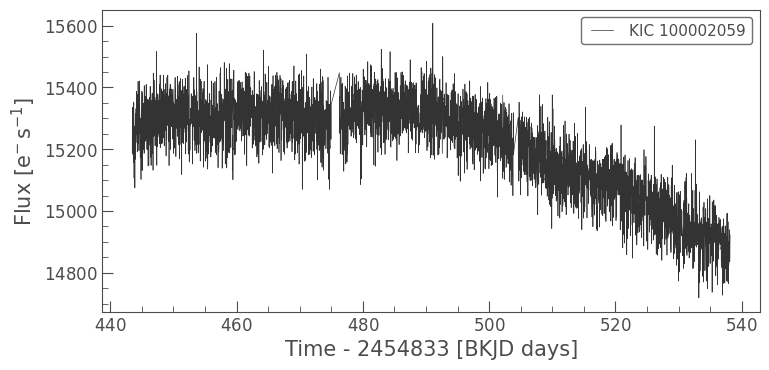

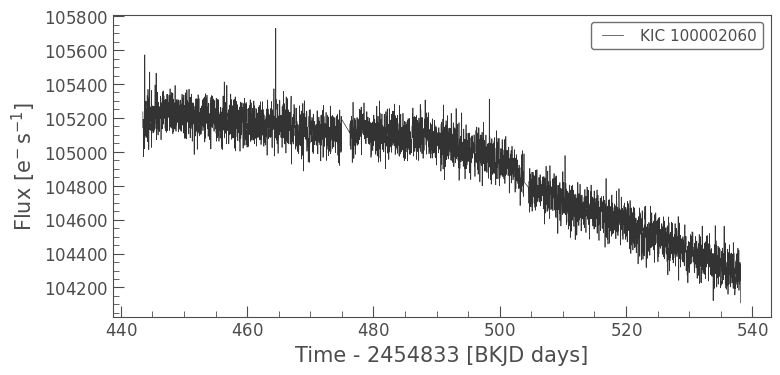

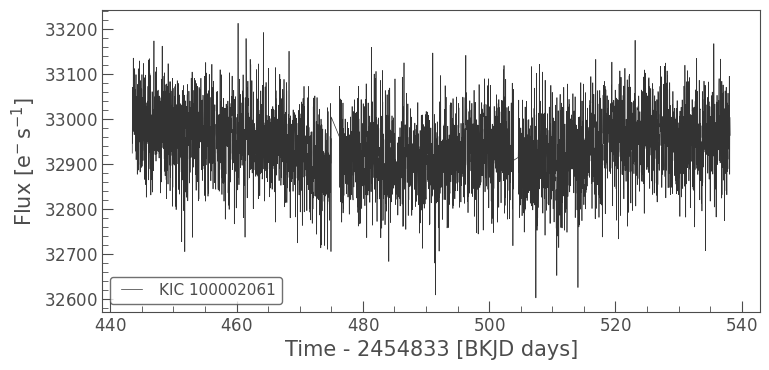

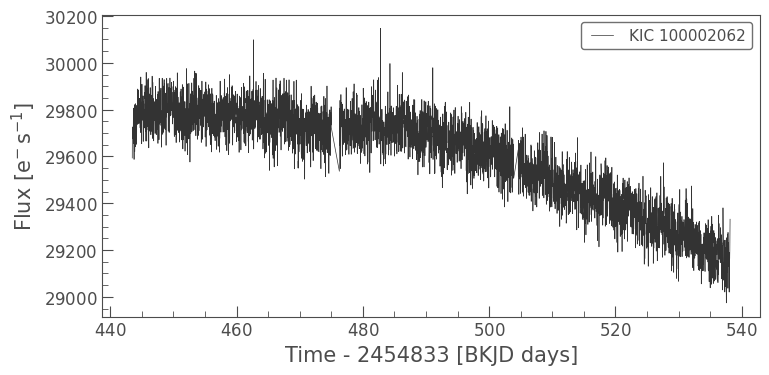

In [10]:
for tpf in tpfs:
    lc = tpf.to_lightcurve(method='aperture').remove_outliers()
    lc.plot()
    plt.show()

### Test PSFMachine

In [11]:
c = Machine.from_TPFs(tpfs)

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
INFO: Query finished. [astroquery.utils.tap.core]
(163, 98)


/Users/jorgemarpa/.pyenv/versions/adap/lib/python3.8/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


## Stitch stripes into one block

In [12]:
def parse_TPFs_channel(tpfs):
    cadences = np.array([tpf.cadenceno for tpf in tpfs])
    # check if all TPFs has same cadences
    if not np.all(cadences[1:, :] - cadences[-1:, :] == 0):
        raise ValueError("All TPFs must have same time basis")
    
    # check if all tpfs are from the same channel
    channels = [tpf.get_header()['CHANNEL']for tpf in tpfs]
    if not len(set(channels)) == 1:
        raise ValueError("All TPFs must be from the same channel")
    
    # make sure tpfs are sorted by colum direction
    test = lk.TargetPixelFileCollection([
        tpfs[i] for i in np.argsort([tpf.column for tpf in tpfs])])
    
    # extract times
    times = tpfs[0].astropy_time.jd
    
    # extract row,column mesh grid
    col, row = np.hstack([np.mgrid[tpf.column : tpf.column + tpf.shape[2], 
                                   tpf.row : tpf.row + tpf.shape[1]] for tpf in tpfs])

    # extract flux vales
    flux = np.hstack([tpf.flux.transpose(1,2,0) for tpf in tpfs]).transpose(2,0,1)
    flux_err = np.hstack([tpf.flux_err.transpose(1,2,0) for tpf in tpfs]).transpose(2,0,1)
    
    # bookkeeping of tpf-pixel
    unw = np.hstack([np.ones(tpf.shape[1:], dtype=np.int)*i for i, tpf in enumerate(tpfs)])
    
    return times, row.T, col.T, flux, flux_err, unw

def convert_to_wcs(tpfs, row, col):
    ra, dec = tpfs[0].wcs.wcs_pix2world((col - tpfs[0].column).ravel(), 
                                        (row - tpfs[0].row).ravel(), 0.0)

    return ra.reshape(row.shape), dec.reshape(row.shape)

def query_gaia(ra, dec, epoch, mag_lim=20):
    ras = ra.mean()
    decs = dec.mean()
    rads = np.hypot(ra - ras.mean(), dec - decs.mean()).max() + (u.arcsecond * 10).to(u.deg).value
    sources = get_gaia_sources(
            tuple([ras]),
            tuple([decs]),
            tuple([rads]),
            magnitude_limit=mag_lim,
            epoch=Time(epoch, format="jd").jyear,
        )
    return sources

In [13]:
times, row, col, flux, flux_err, unw = parse_TPFs_channel(tpfs)
ra, dec = convert_to_wcs(tpfs, row, col)

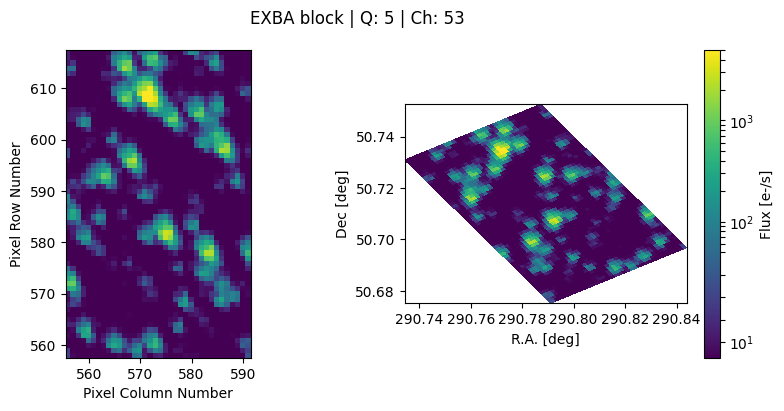

In [109]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle('EXBA block | Q: %i | Ch: %i' % (tpfs[0].get_header()["QUARTER"],
                                              tpfs[0].get_header()["CHANNEL"]))
ax[0].pcolormesh(col, row, flux[0], shading='auto',
                   norm=colors.SymLogNorm(linthresh=50, vmin=3, vmax=5000, base=10))
ax[0].set_aspect('equal', adjustable='box')
ax[0].set_xlabel('Pixel Column Number')
ax[0].set_ylabel('Pixel Row Number')

pc = ax[1].pcolormesh(ra, dec, flux[0], shading='auto',
                   norm=colors.SymLogNorm(linthresh=50, vmin=3, vmax=5000, base=10))
ax[1].set_xlabel('R.A. [deg]')
ax[1].set_ylabel('Dec [deg]')
fig.colorbar(pc, label='Flux [e-/s]')
ax[1].set_aspect('equal', adjustable='box')
plt.show()

In [98]:
def clean_source_list(sources, ra, dec):
    # find sources on the image
    inside = np.zeros(len(sources), dtype=bool)
    # max distance in arcsec from image edge to source ra, dec
    off = 6.0 / 3600
    for k in range(len(sources)):
        raok = (sources["ra"][k] > ra - off) & (sources["ra"][k] < ra + off)
        decok = (sources["dec"][k] > dec - off) & (sources["dec"][k] < dec + off)
        inside[k] = (raok & decok).any()
    del raok, decok

    # find well separated sources
    s_coords = SkyCoord(sources.ra, sources.dec, unit=("deg"))
    midx, mdist = match_coordinates_3d(s_coords, s_coords, nthneighbor=2)[:2]
    # remove sources closer than 4" = 1 pix
    closest = mdist.arcsec < 2.0
    blocs = np.vstack([midx[closest], np.where(closest)[0]])
    bmags = np.vstack(
        [
            sources.phot_g_mean_mag[midx[closest]],
            sources.phot_g_mean_mag[np.where(closest)[0]],
        ]
    )
    faintest = [blocs[idx][s] for s, idx in enumerate(np.argmax(bmags, axis=0))]
    unresolved = np.in1d(np.arange(len(sources)), faintest)
    del s_coords, midx, mdist, closest, blocs, bmags

    # Keep track of sources that we removed
    sources.loc[:, "clean_flag"] = 0
    sources.loc[:, "clean_flag"].iloc[~inside] += 2 ** 0  # outside TPF
    sources.loc[:, "clean_flag"].iloc[unresolved] += 2 ** 1  # close contaminant

    # combine 2 source masks
    clean = sources.clean_flag == 0
    removed_sources = sources[~clean].reset_index(drop=True)
    sources = sources[clean].reset_index(drop=True)

    return sources, removed_sources

In [99]:
sources = Machine._get_coord_and_query_gaia(ra.ravel(), dec.ravel(), 
                                            unw.ravel(), times[0], magnitude_limit=25)
sources, bad_sources = clean_source_list(sources, ra.ravel(), dec.ravel())

sources['col'], sources['row'] = tpfs[0].wcs.wcs_world2pix(sources.ra, sources.dec, 0.5)

/Users/jorgemarpa/.pyenv/versions/adap/lib/python3.8/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


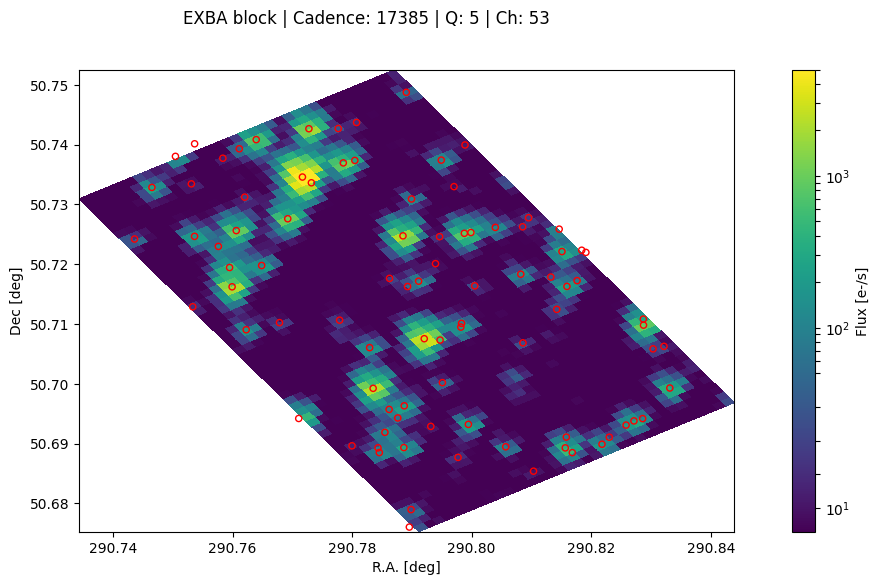

In [108]:
fig, ax = plt.subplots(1, 1, figsize=(15,6))
fig.suptitle('EXBA block | Cadence: %i | Q: %i | Ch: %i' % (tpfs[0].cadenceno[1000],
                                                            tpfs[0].get_header()["QUARTER"],
                                                            tpfs[0].get_header()["CHANNEL"]))
pc = ax.pcolormesh(ra, dec, flux[1000], shading='auto',
                   norm=colors.SymLogNorm(linthresh=50, vmin=3, vmax=5000, base=10))
ax.scatter(sources.ra, sources.dec, s=20, facecolors='none', 
           marker='o', edgecolors='r', label='Gaia results')
ax.set_xlabel('R.A. [deg]')
ax.set_ylabel('Dec [deg]')
fig.colorbar(pc, label='Flux [e-/s]')
ax.set_aspect('equal', adjustable='box')
plt.show()

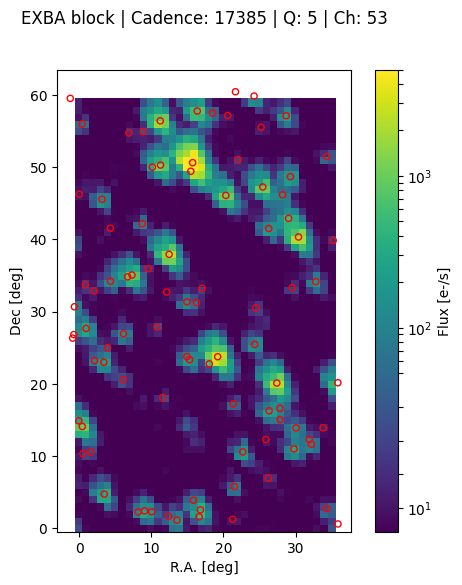

In [107]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
fig.suptitle('EXBA block | Cadence: %i | Q: %i | Ch: %i' % (tpfs[0].cadenceno[1000],
                                                            tpfs[0].get_header()["QUARTER"],
                                                            tpfs[0].get_header()["CHANNEL"]))
pc = ax.pcolormesh(col - col.min(), row - row.min(), flux[1000], shading='auto',
                   norm=colors.SymLogNorm(linthresh=50, vmin=3, vmax=5000, base=10))
ax.scatter(sources.col, sources.row, s=20, facecolors='none', 
           marker='o', edgecolors='r', label='Gaia results')
ax.set_xlabel('R.A. [deg]')
ax.set_ylabel('Dec [deg]')
fig.colorbar(pc, label='Flux [e-/s]')
ax.set_aspect('equal', adjustable='box')
plt.show()

## Aperture Photometry

In [124]:
def fast_sap(ra, dec, flux, flux_err, sources, space='world'):
    if space == 'world':
        aper = (u.arcsecond * 2 * 4).to(u.deg).value # aperture radii in deg
        aperture_mask = [np.hypot(ra - s.ra, dec - s.dec) < aper for _, s in sources.iterrows()]
    elif space == 'pix-cir':
        aper = 2
        aperture_mask = [np.hypot(ra - s.col, dec - s.row) < aper for _, s in sources.iterrows()]
    elif space == 'pix-sq':
        aper = [1.5, 1.5]
        aperture_mask = [(np.abs(ra - s.col) < aper[1]) & 
                         (np.abs(dec - s.row) < aper[0]) for _, s in sources.iterrows()]
    
    sap = np.zeros((sources.shape[0], flux.shape[0]))
    sap_e = np.zeros((sources.shape[0], flux.shape[0]))
    
    for tdx in tqdm(range(len(flux)), desc='Simple SAP flux'):
        sap[:, tdx] = [flux[tdx][mask].sum() for mask in aperture_mask]
        sap_e[:, tdx] = [np.power(flux_err[tdx][mask], 2).sum() ** 0.5 for mask in aperture_mask]
        
    return sap, sap_e, np.asarray(aperture_mask)

In [130]:
def dummy_sap(ra, dec, flux, flux_err, sources, space='world'):
    if space == 'world':
        aper = (u.arcsecond * 2 * 4).to(u.deg).value # aperture radii in deg
        aperture_mask = [np.hypot(ra - s.ra, dec - s.dec) < aper for _, s in sources.iterrows()]
    elif space == 'pix-cir':
        aper = 1.7
        aperture_mask = [np.hypot(ra - s.col, dec - s.row) < aper for _, s in sources.iterrows()]
    elif space == 'pix-sq':
        aper = [1.5, 1.5]
        aperture_mask = [(np.abs(ra - s.col) < aper[1]) & 
                         (np.abs(dec - s.row) < aper[0]) for _, s in sources.iterrows()]
    
    sap = np.zeros((sources.shape[0], flux.shape[0]))
    sap_e = np.zeros((sources.shape[0], flux.shape[0]))
    
    for tdx in tqdm(range(len(flux)), desc='Simple SAP flux'):
        sap[:, tdx] = [flux[tdx][mask].sum() for mask in aperture_mask]
        sap_e[:, tdx] = [np.power(flux_err[tdx][mask], 2).sum() ** 0.5 for mask in aperture_mask]
        
    return sap, sap_e, np.asarray(aperture_mask)

In [133]:
sap, sap_err, ap_mask = dummy_sap(col - tpfs[0].column, row - tpfs[0].row, 
                                  flux, flux_err, sources, space='pix-sq')

Simple SAP flux:   0%|          | 0/4492 [00:00<?, ?it/s]

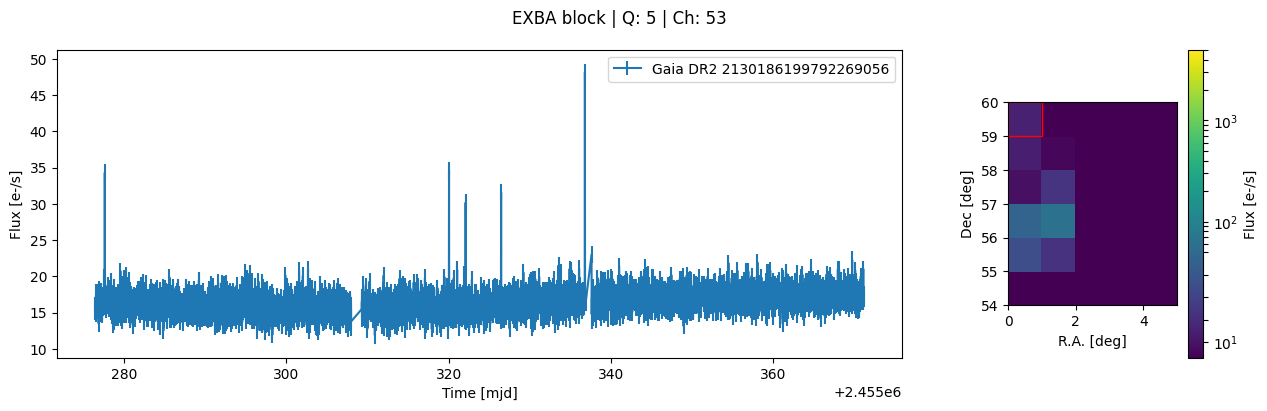

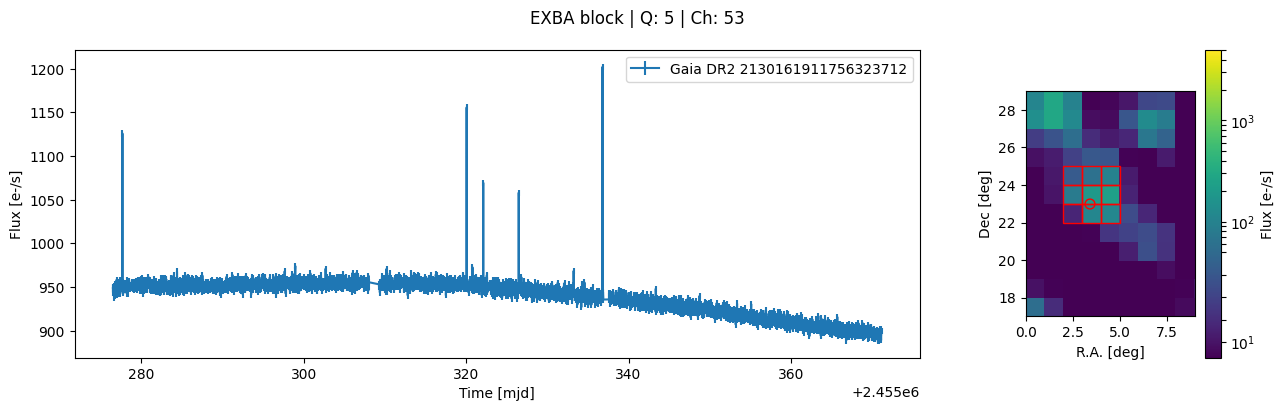

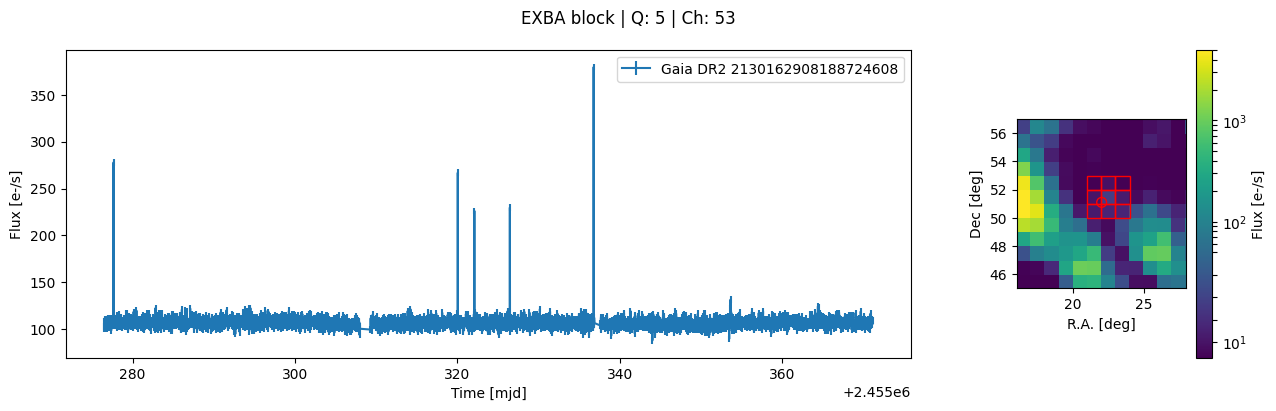

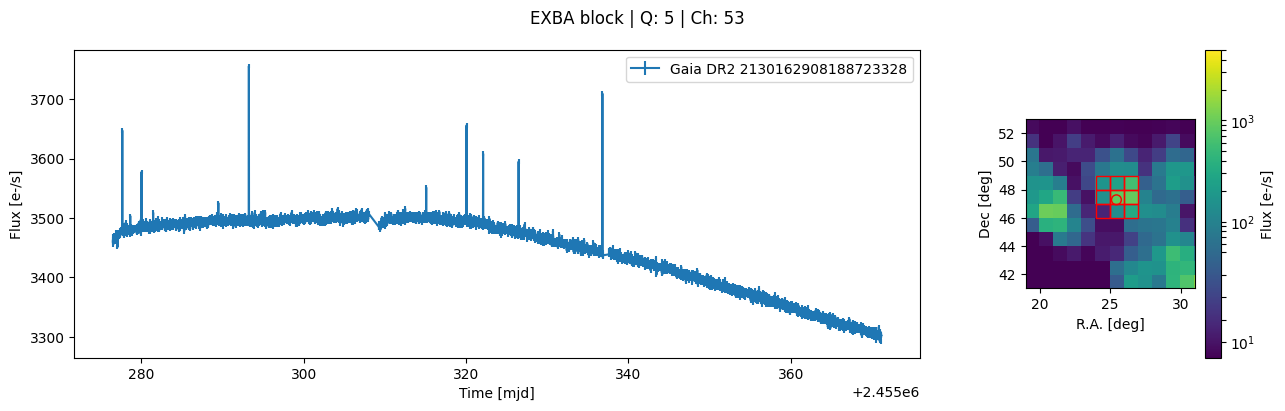

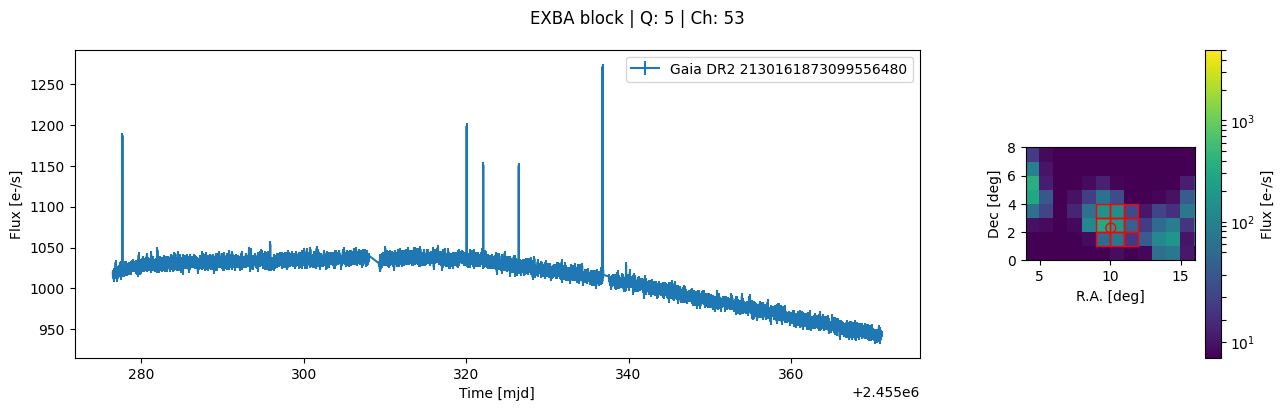

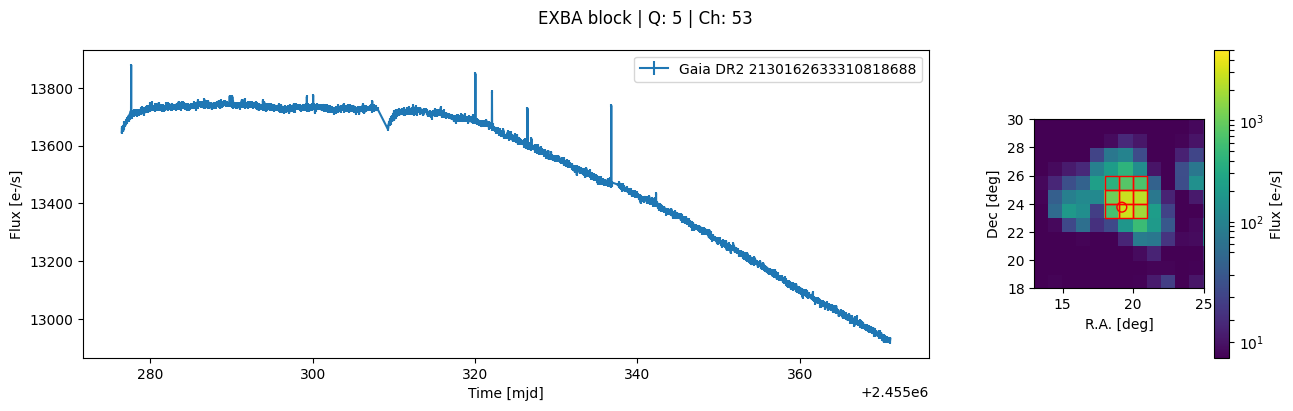

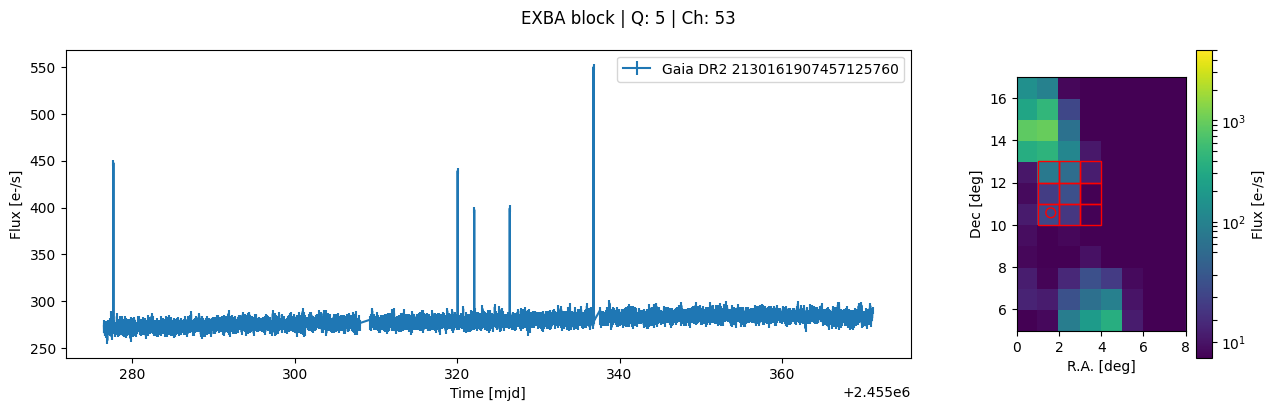

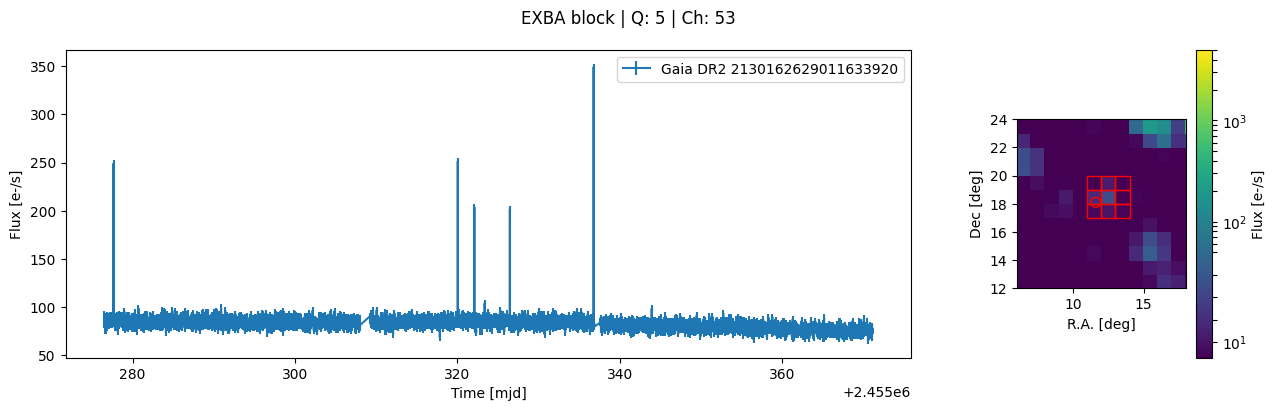

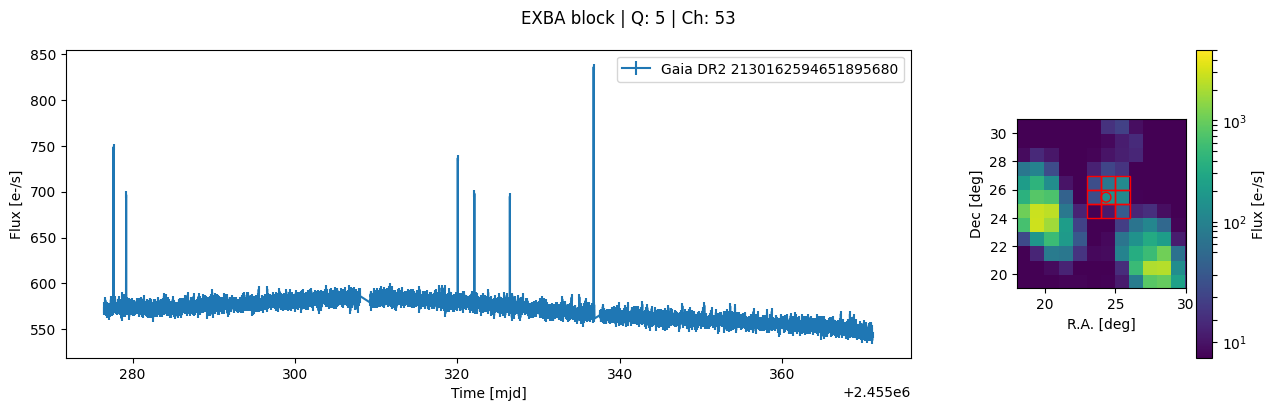

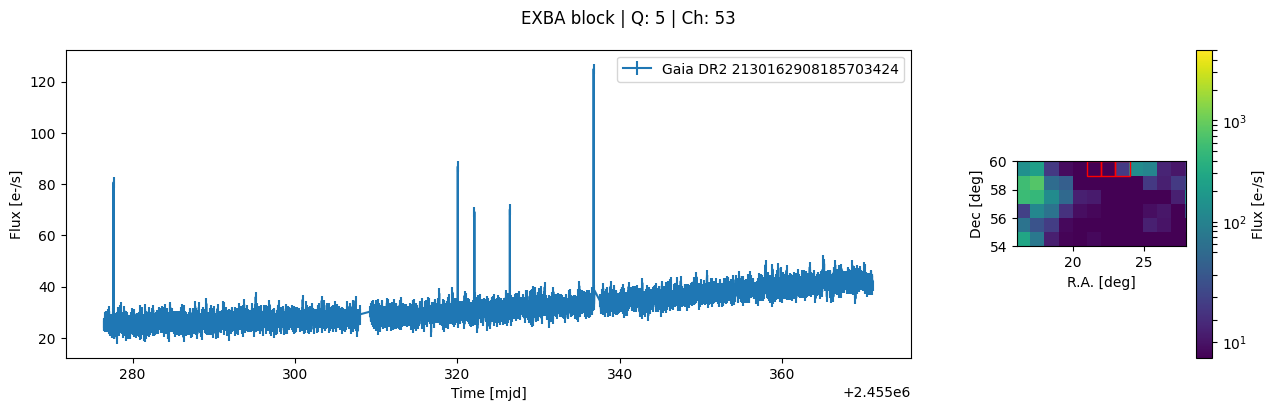

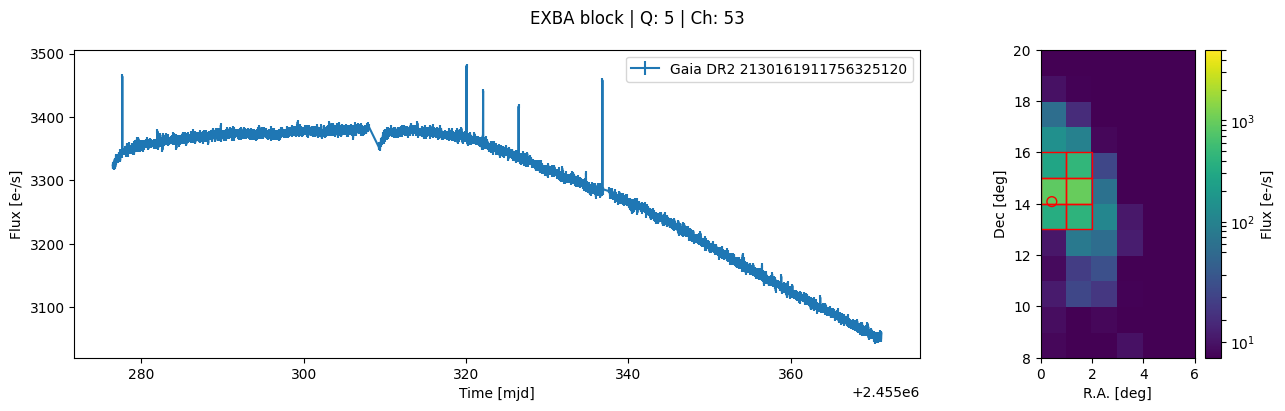

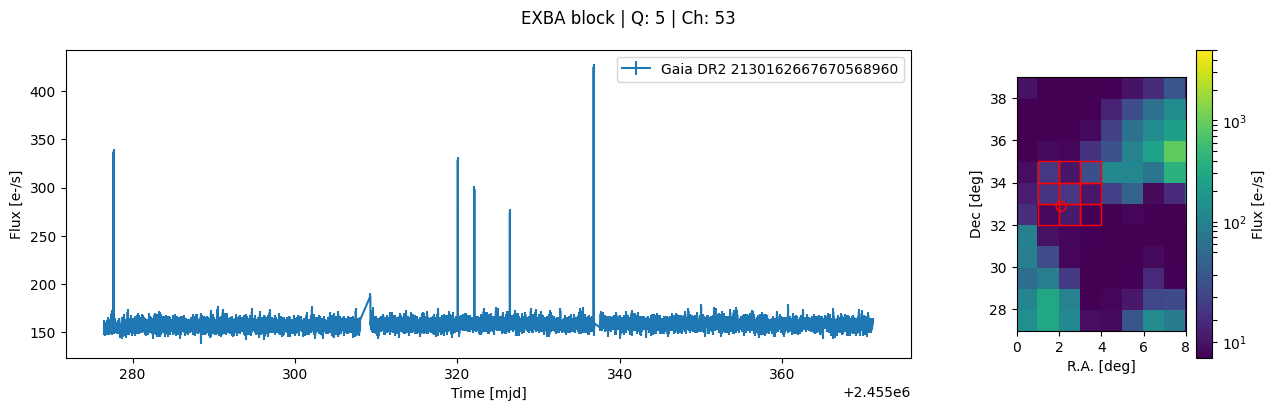

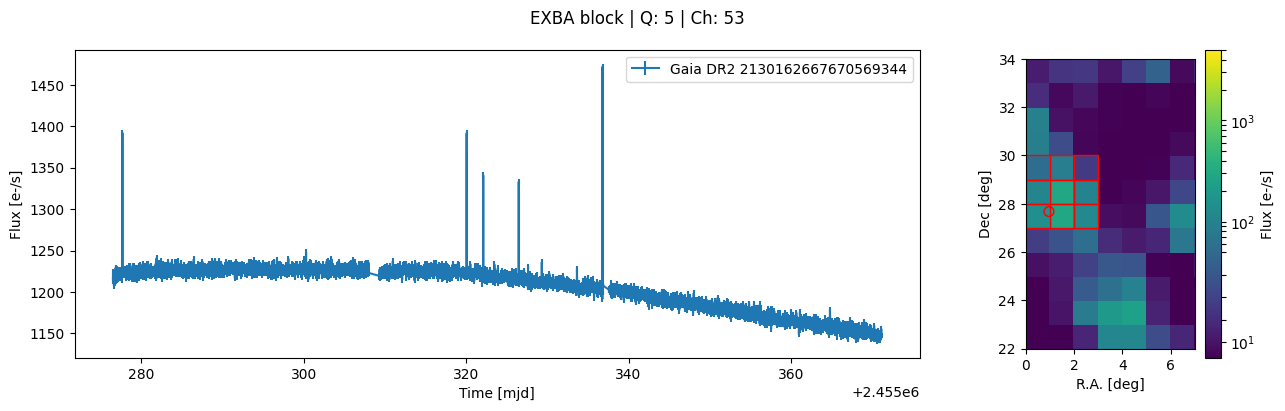

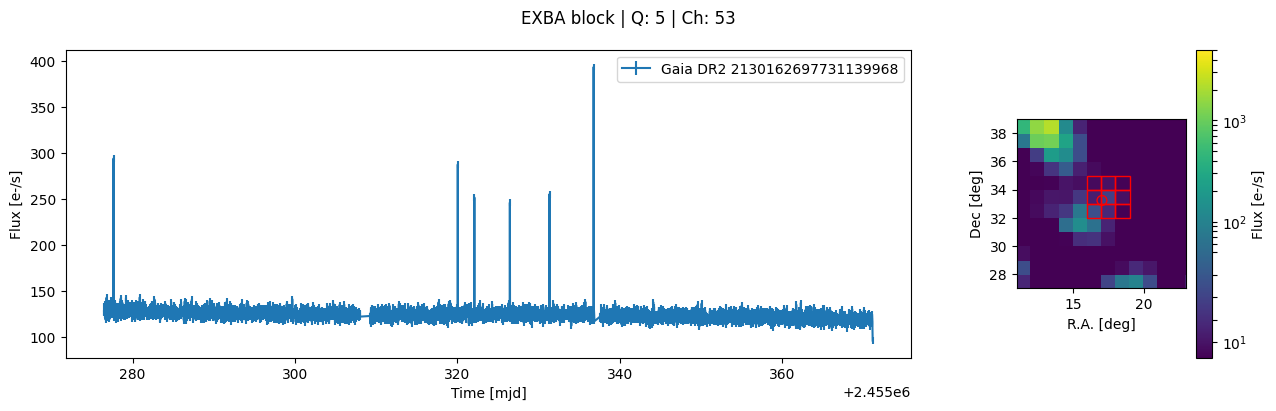

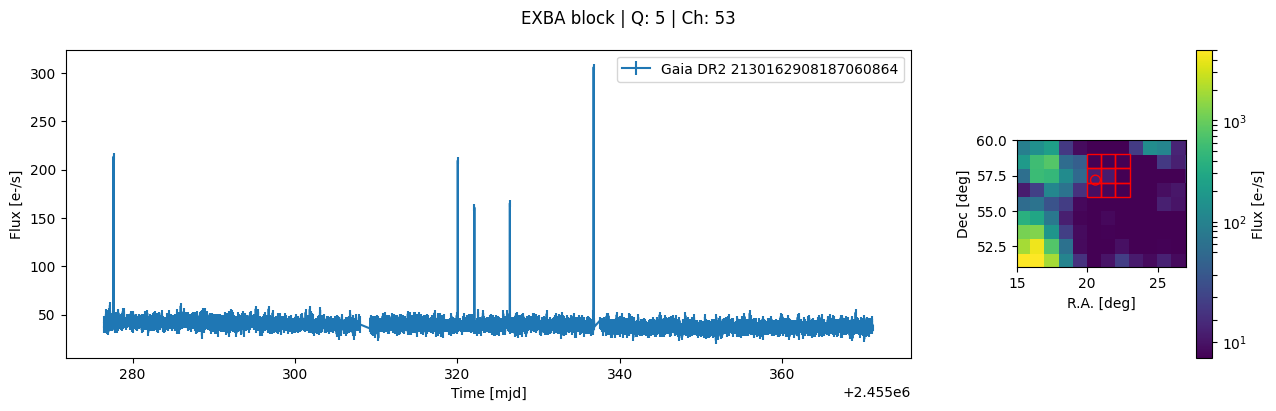

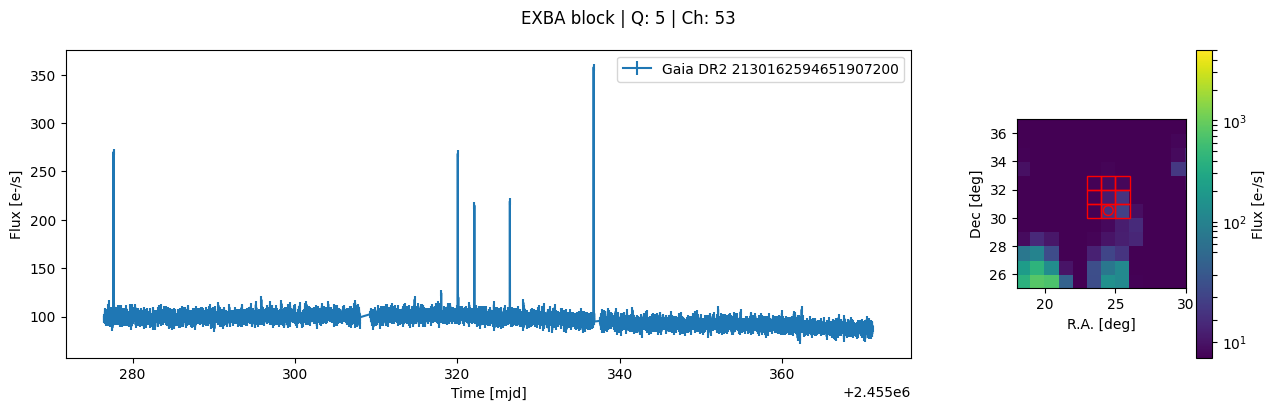

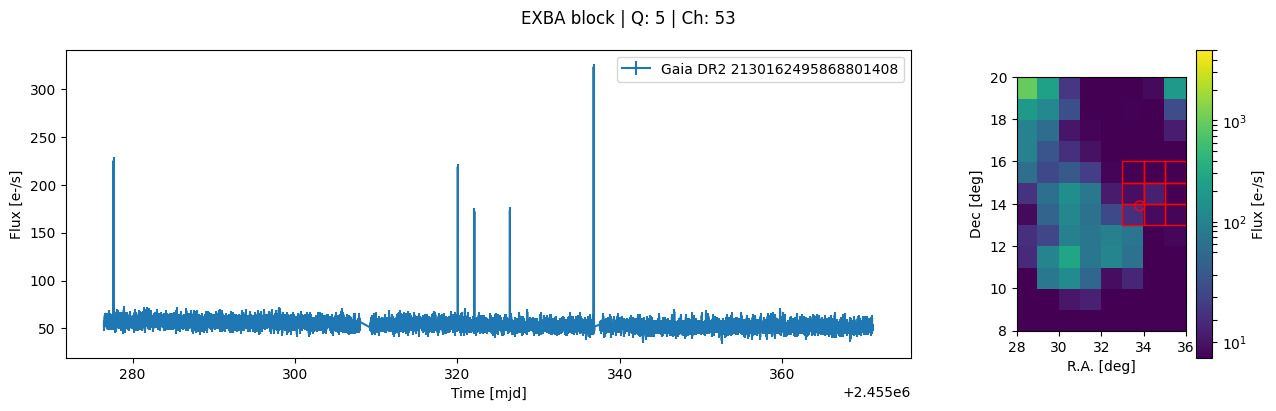

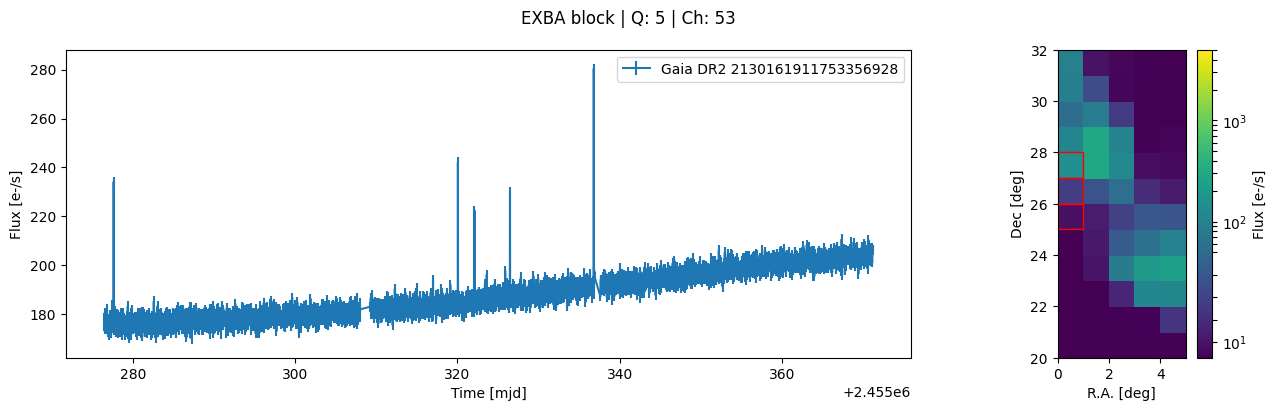

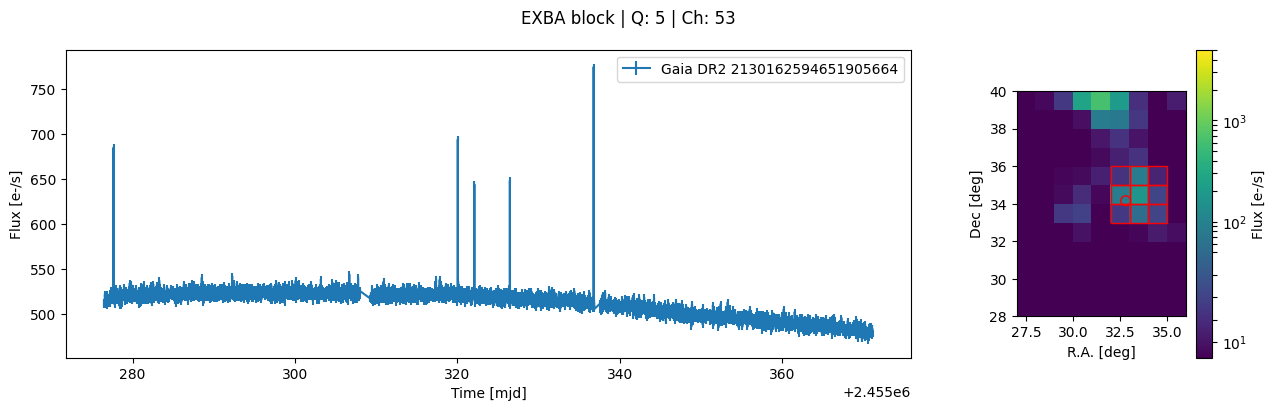

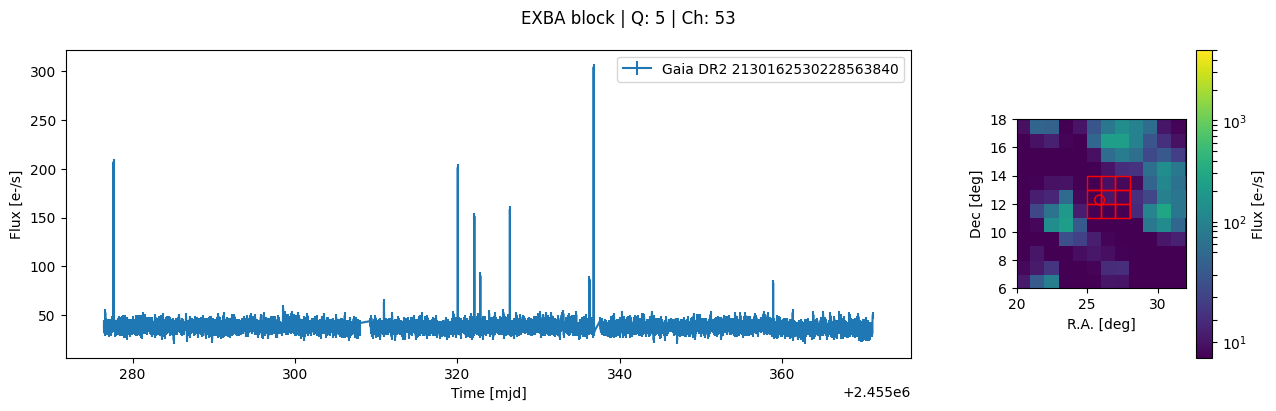

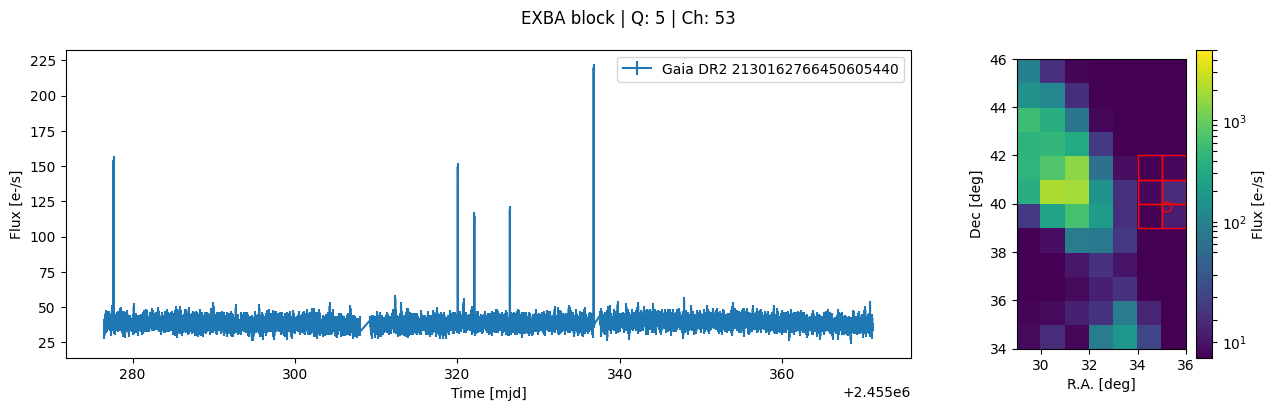

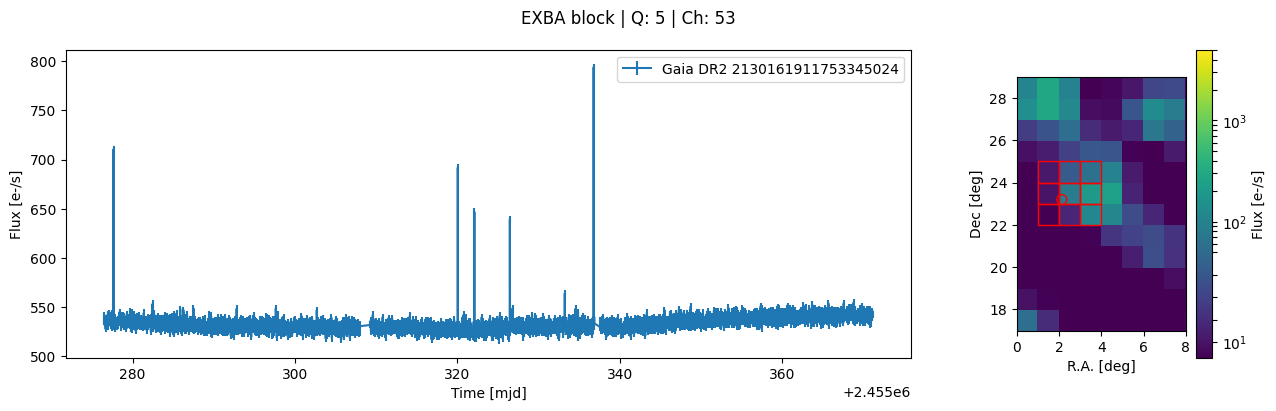

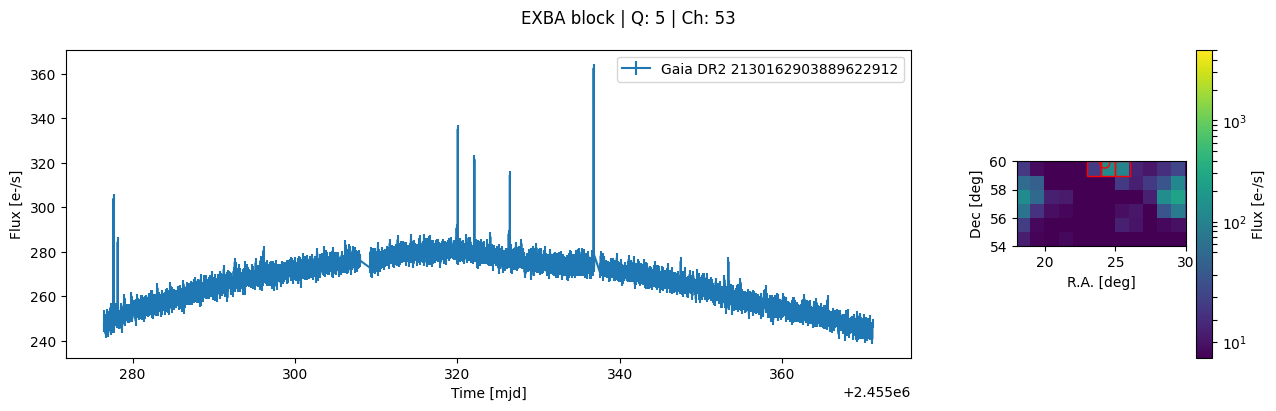

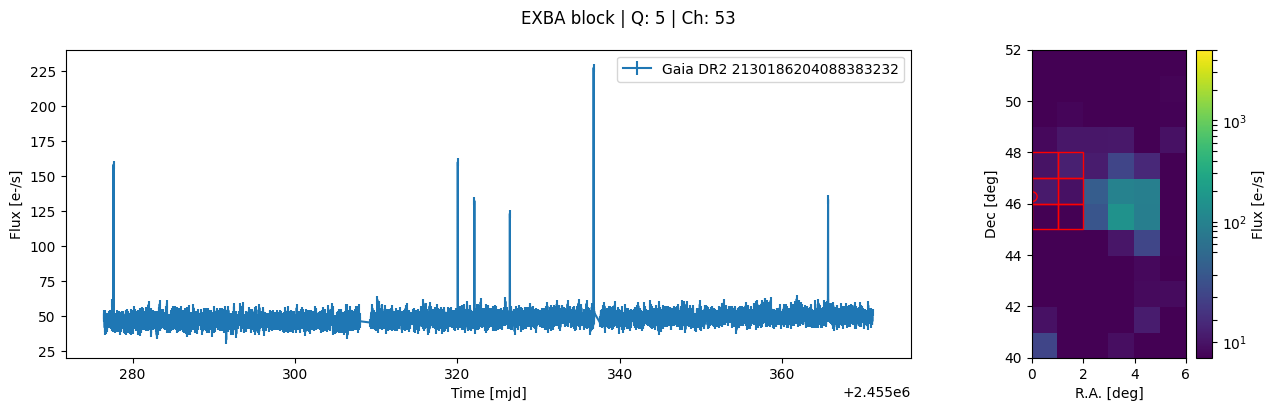

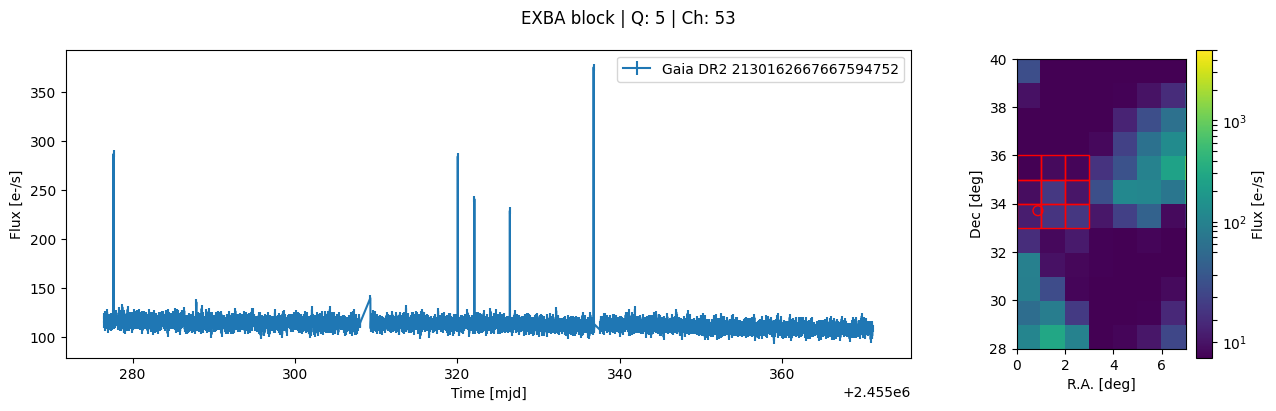

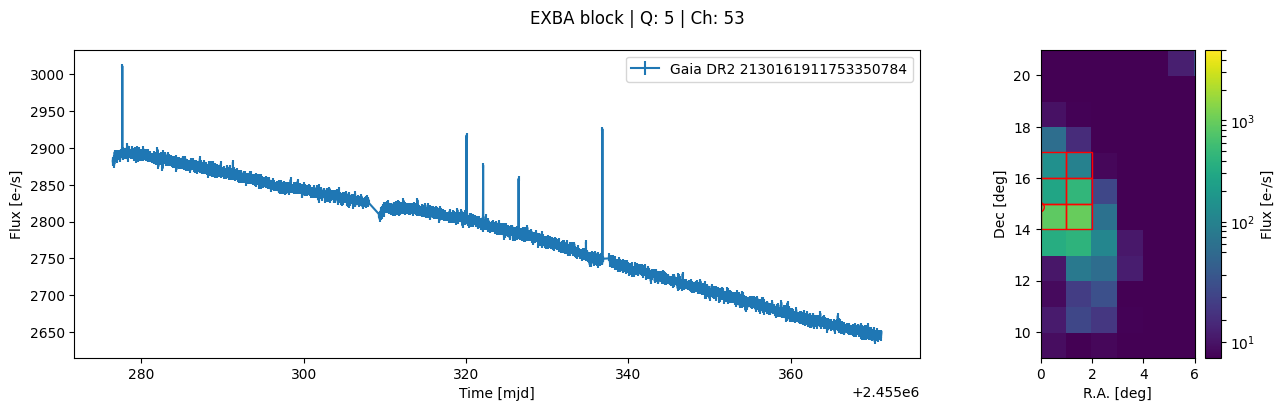

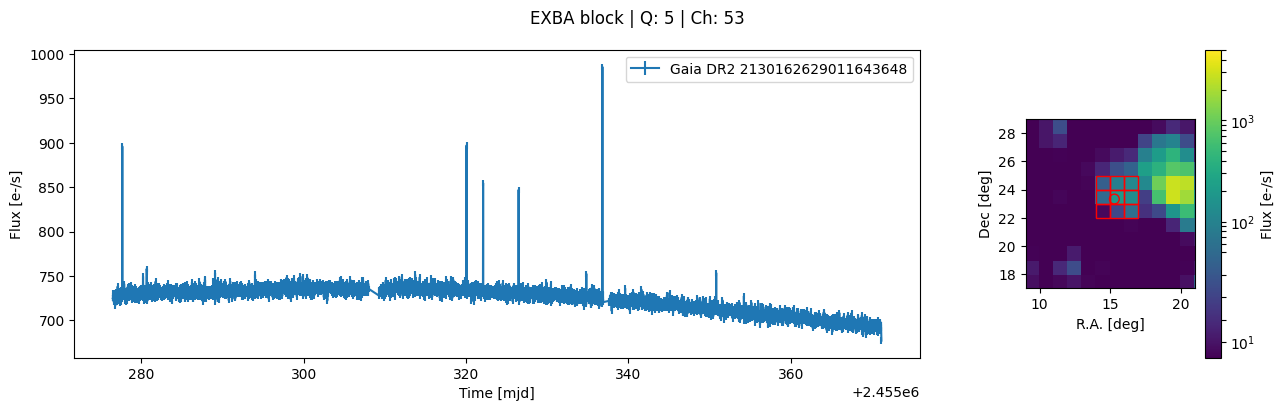

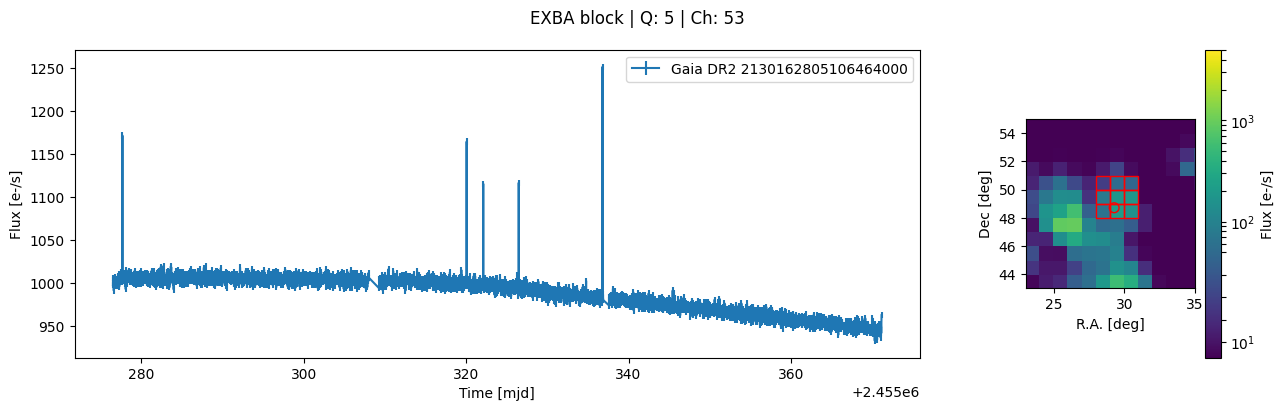

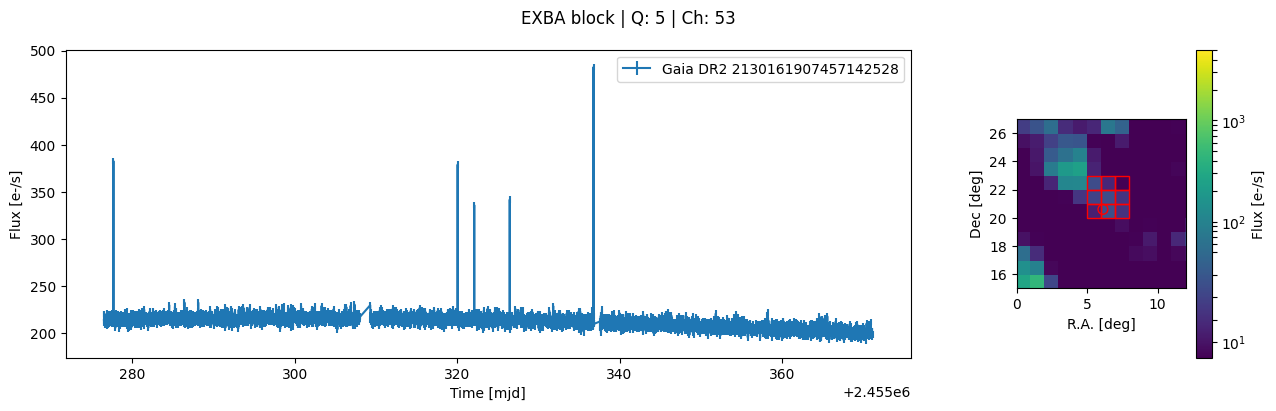

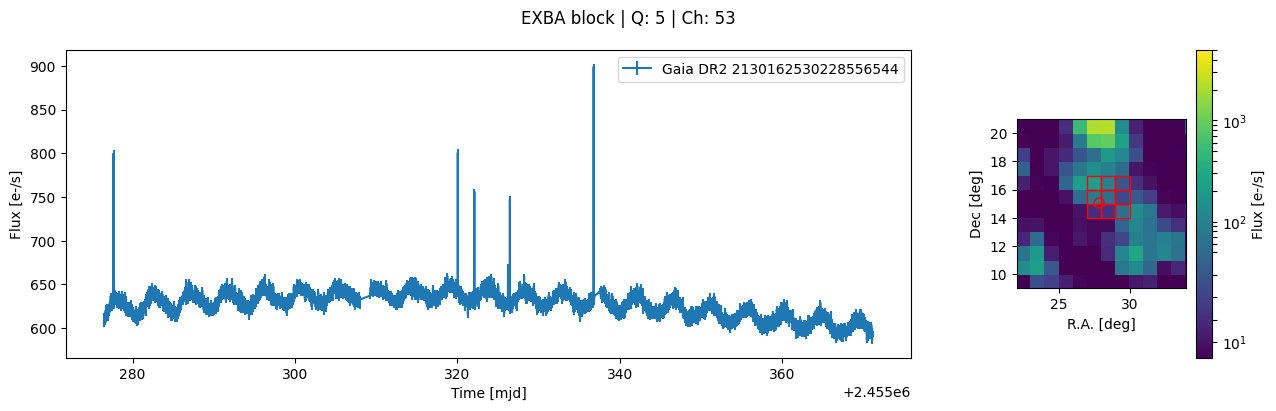

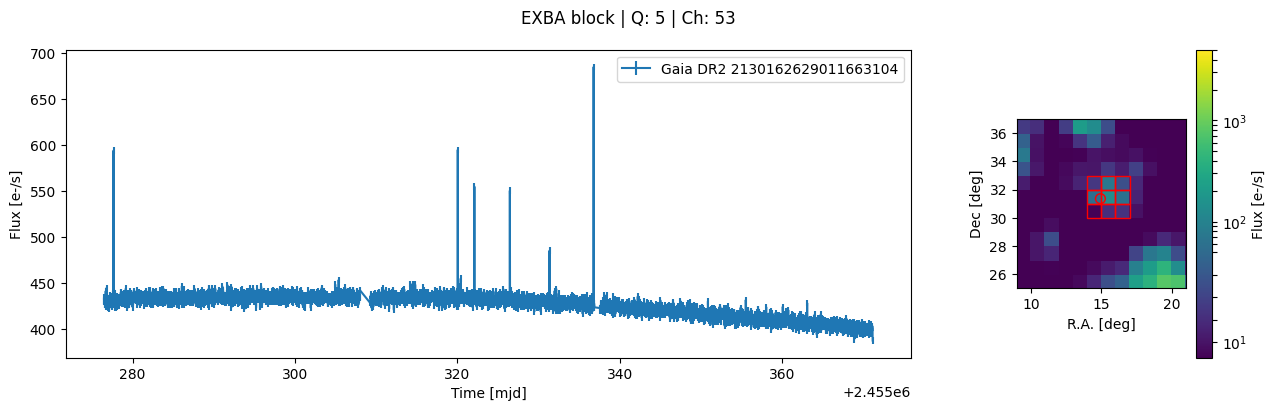

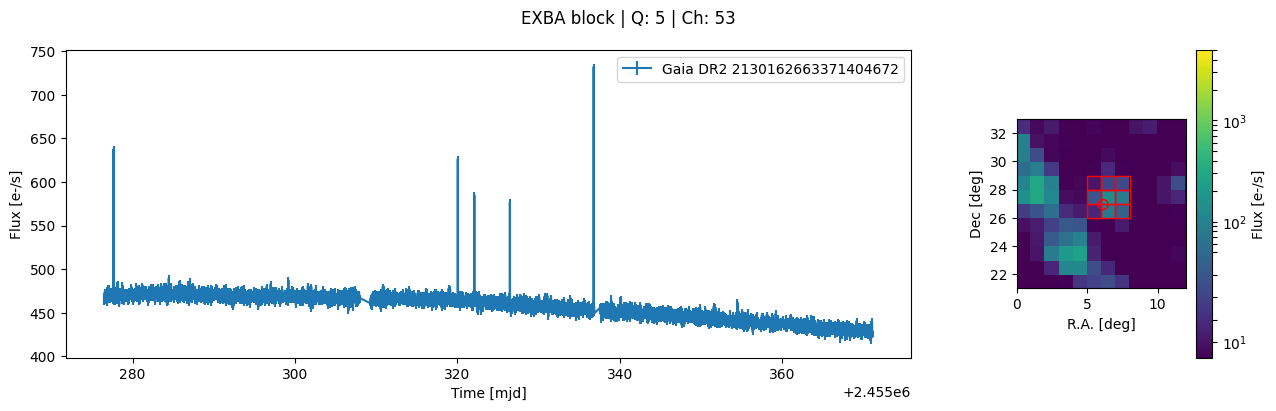

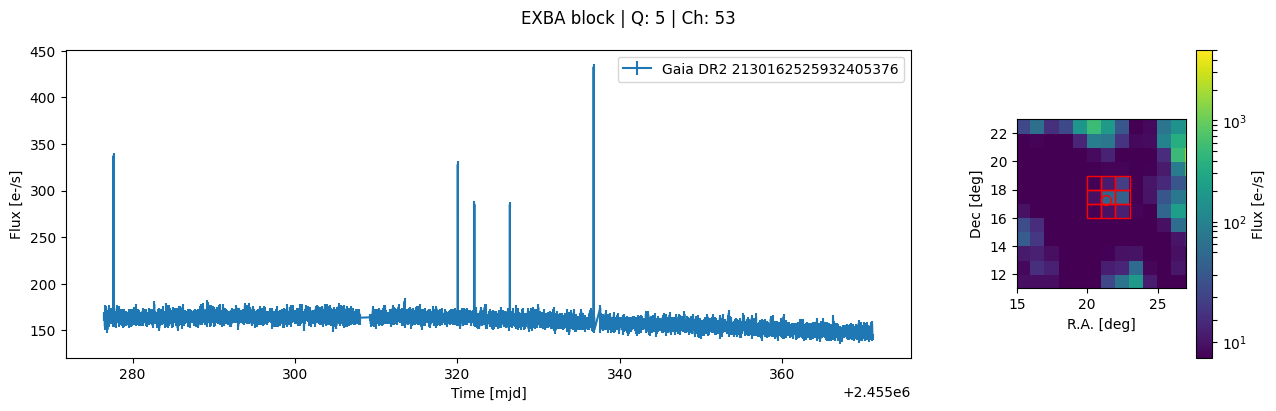

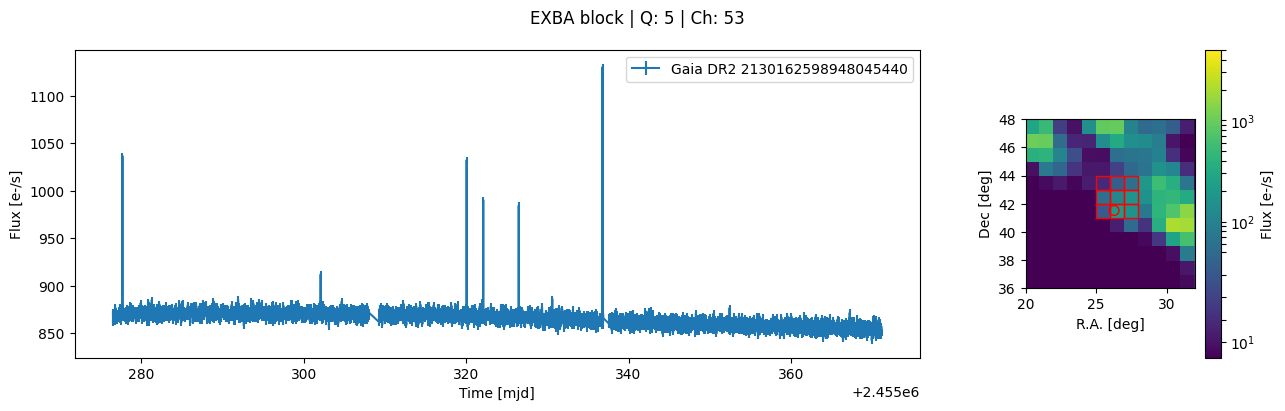

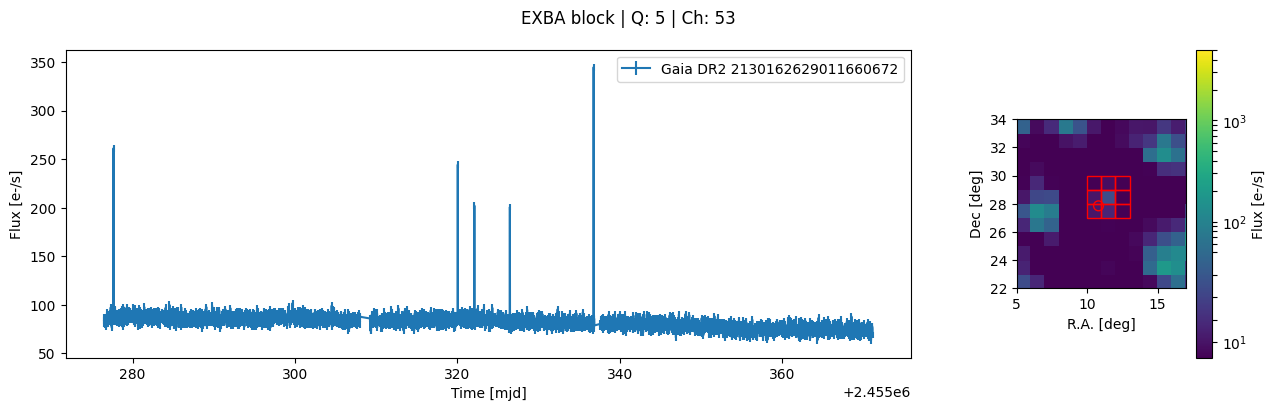

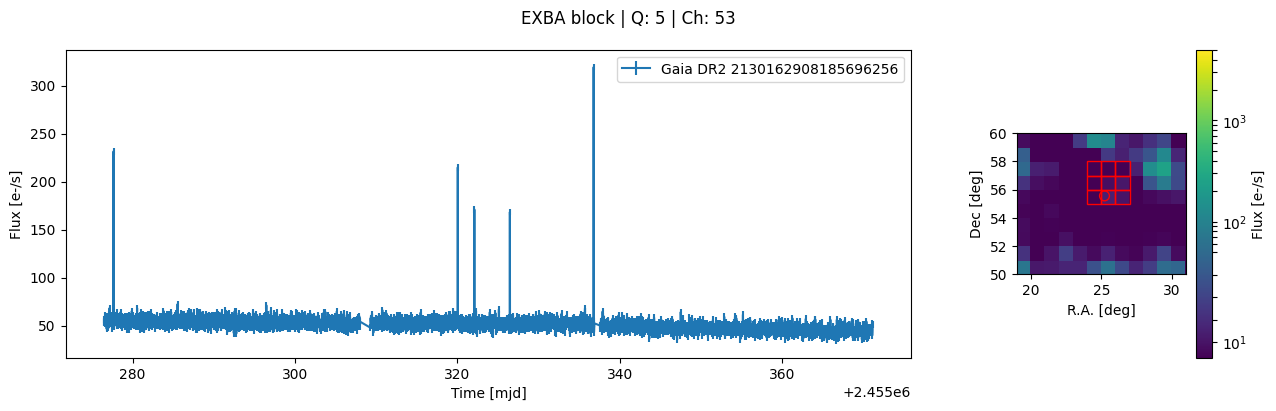

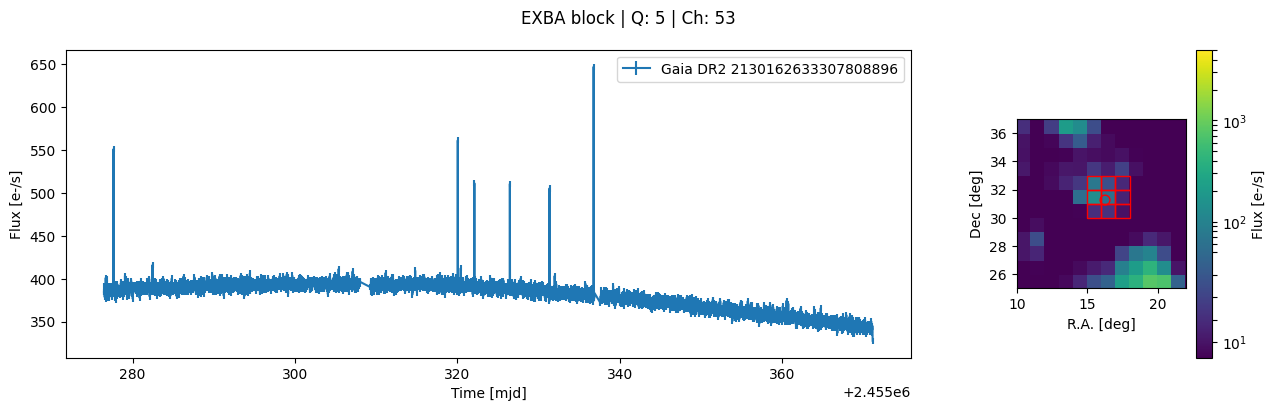

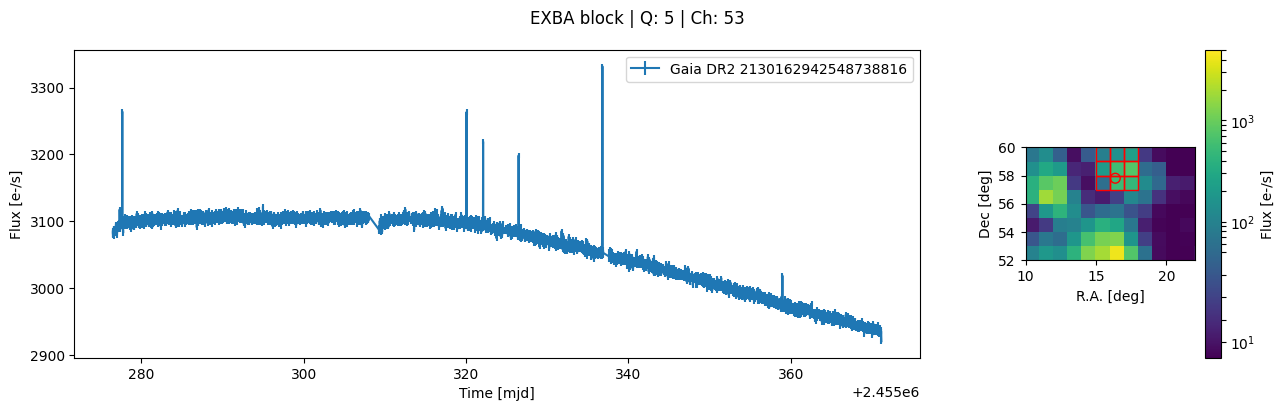

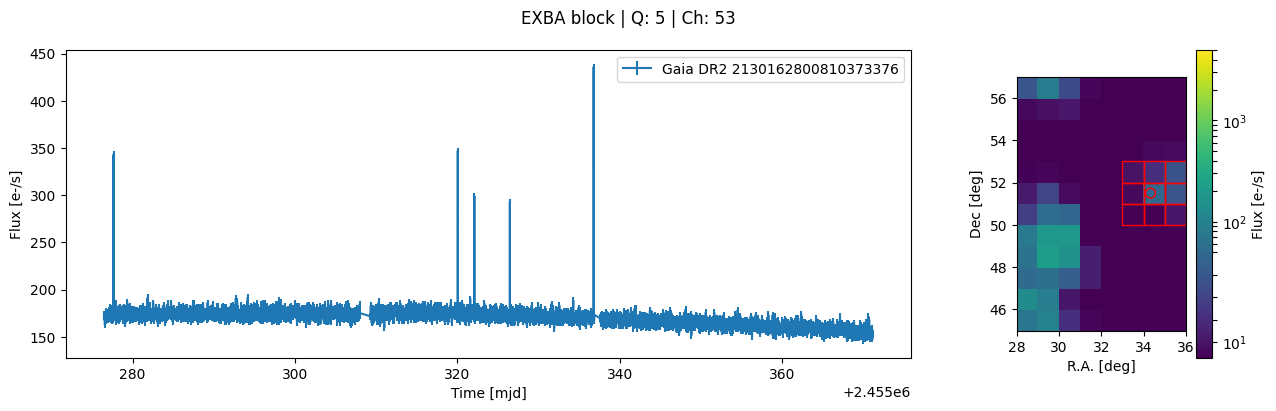

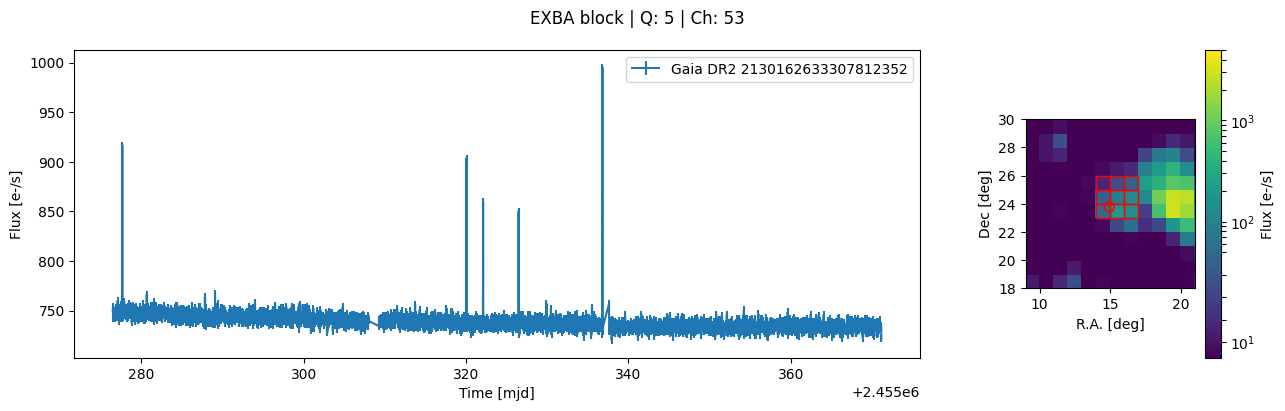

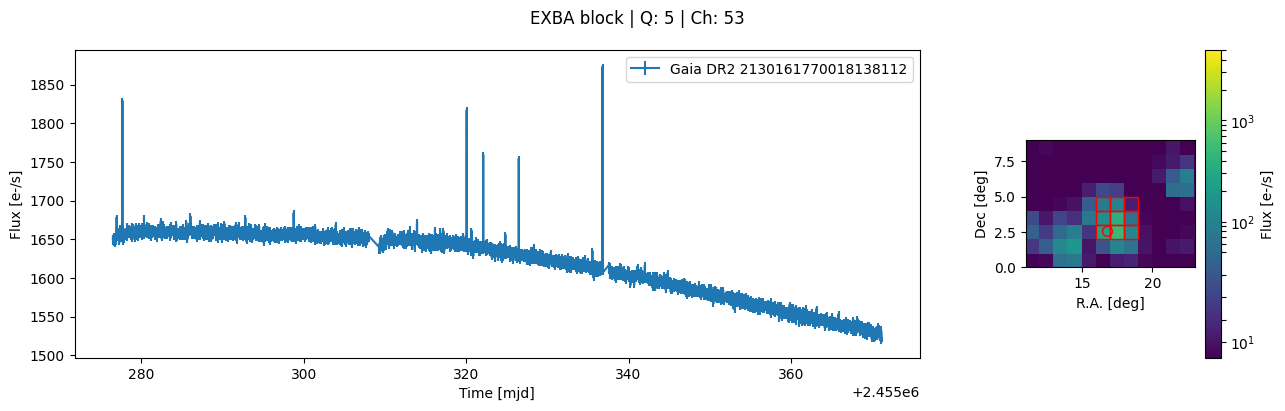

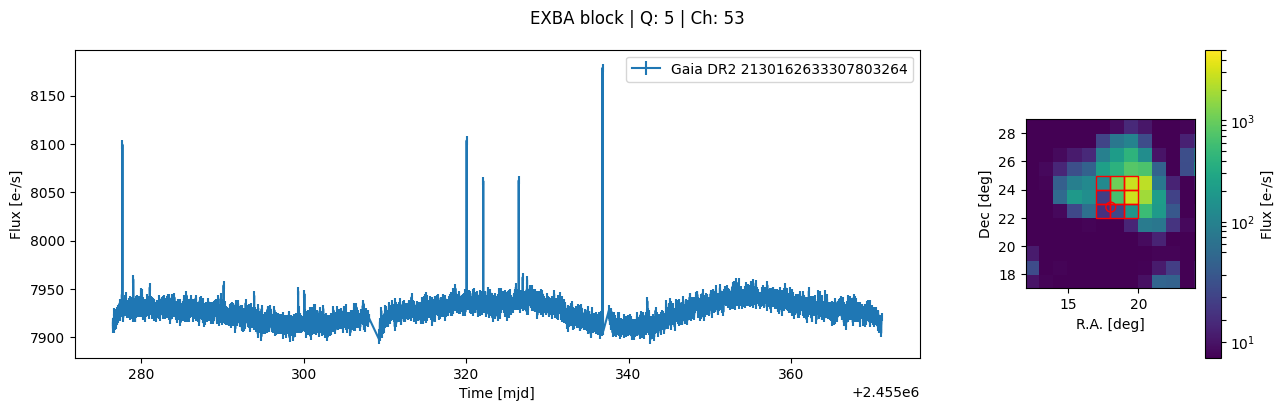

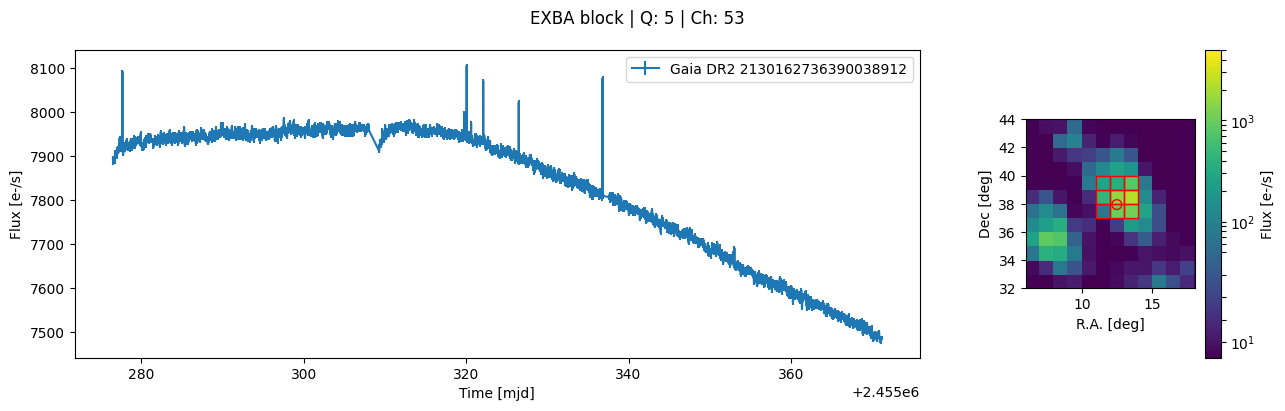

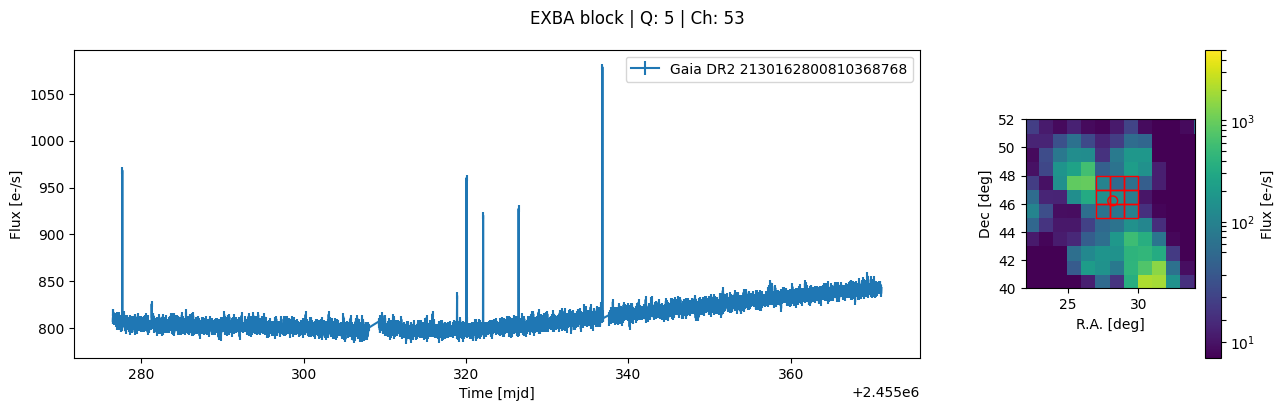

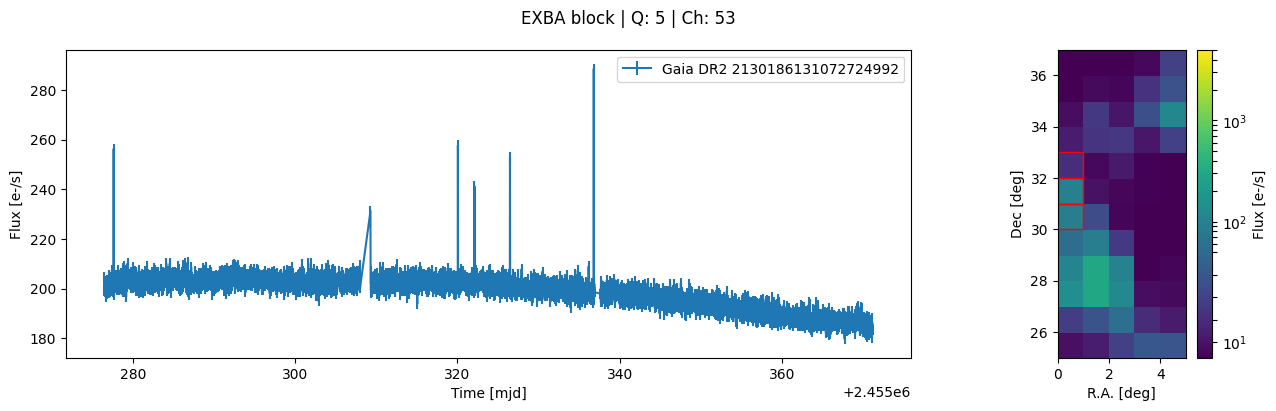

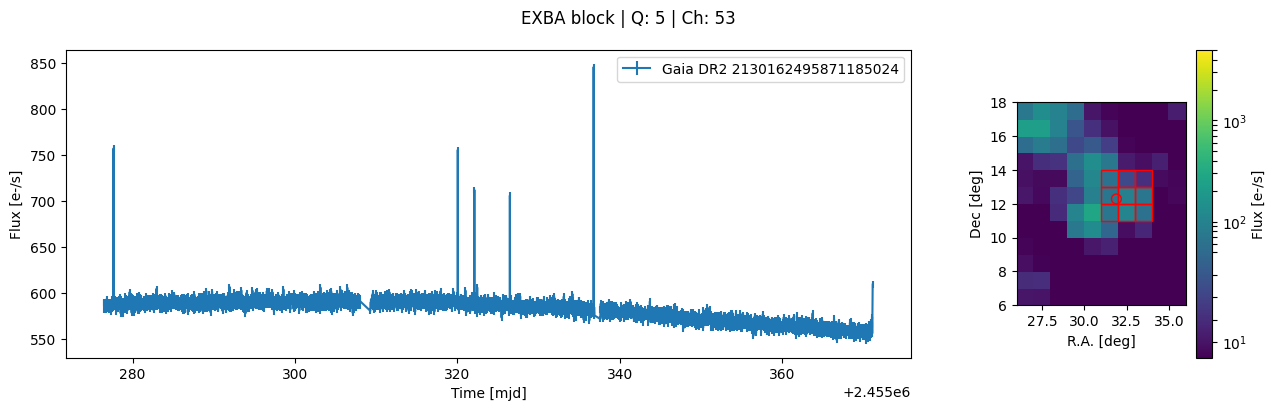

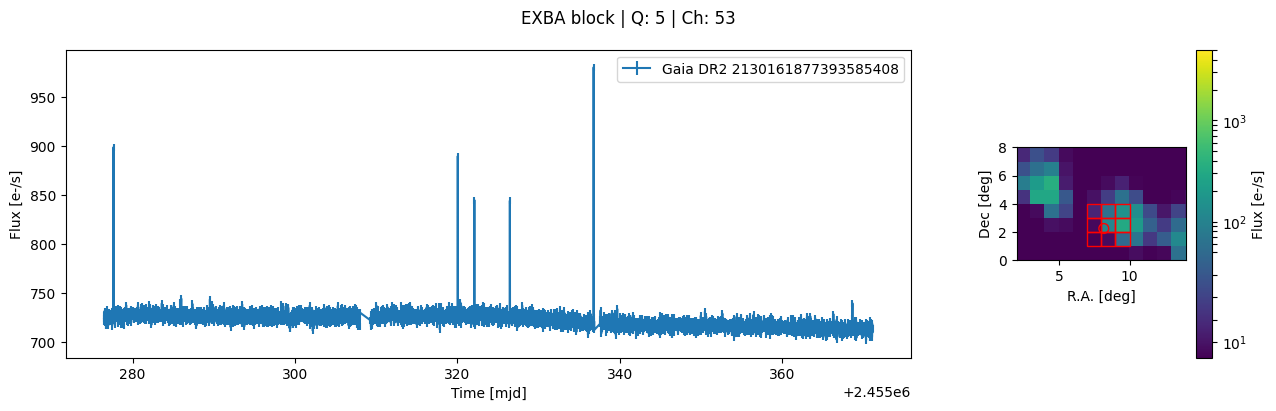

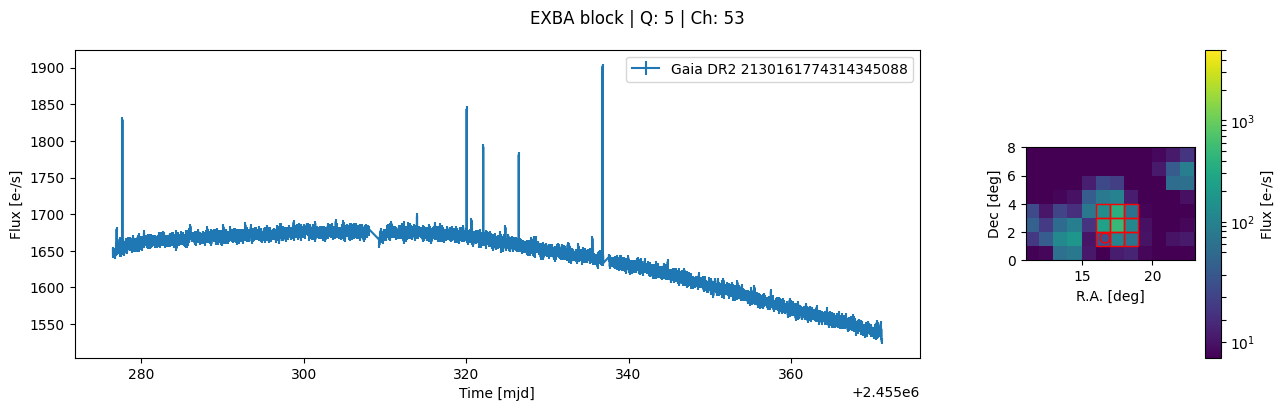

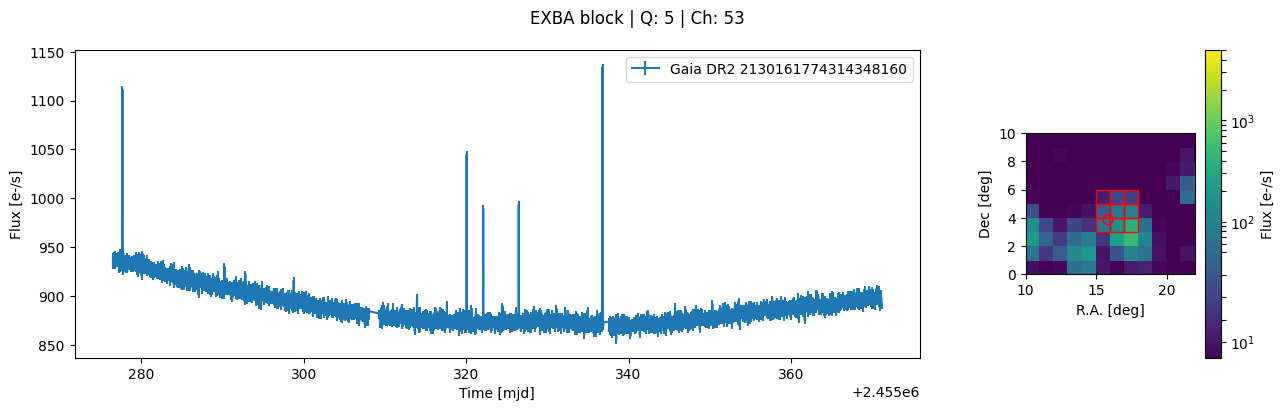

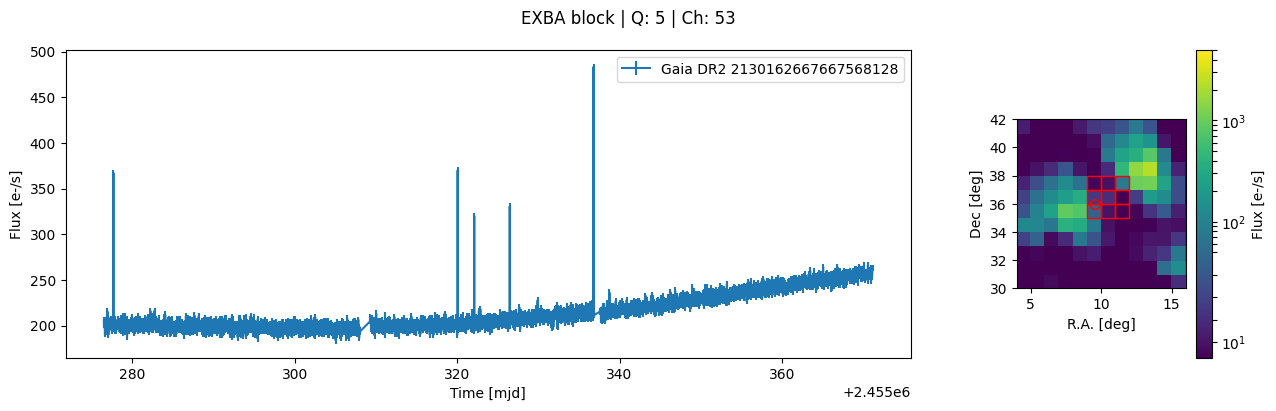

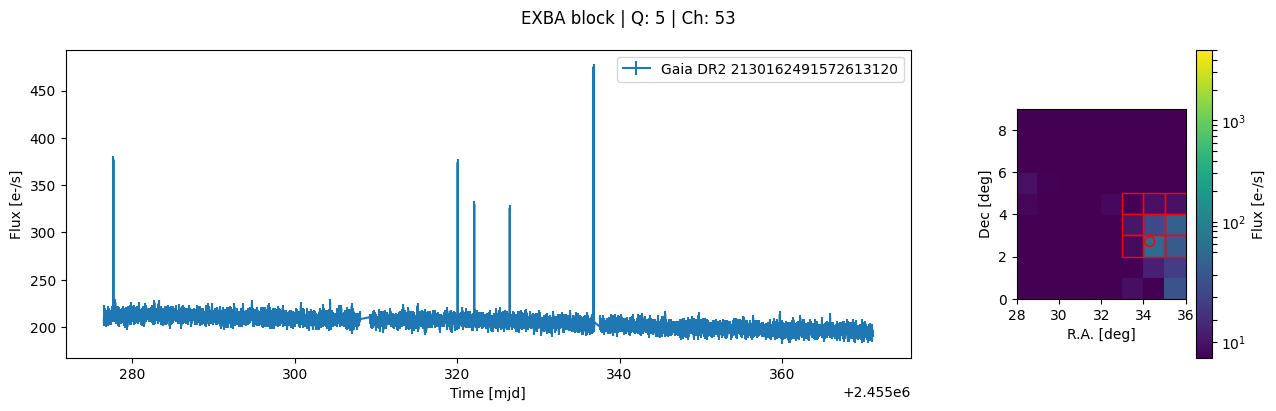

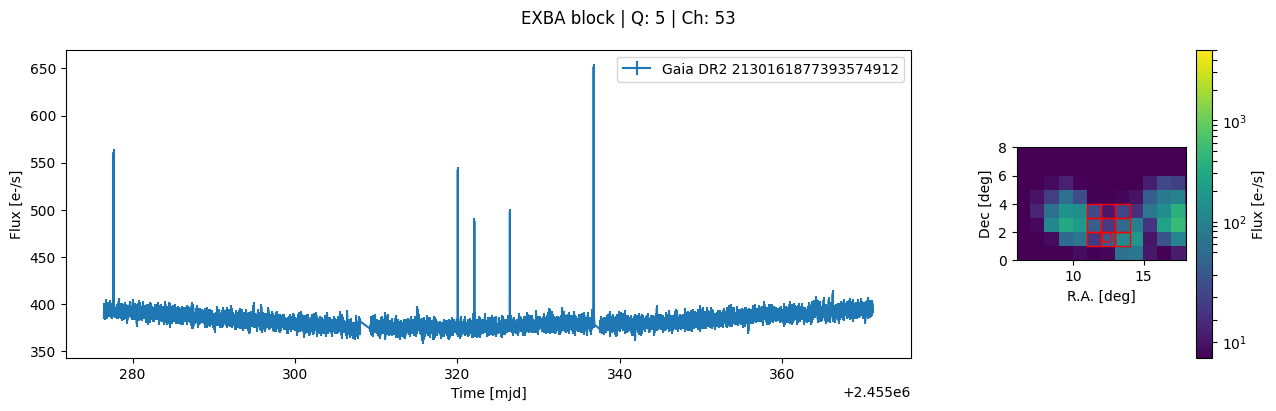

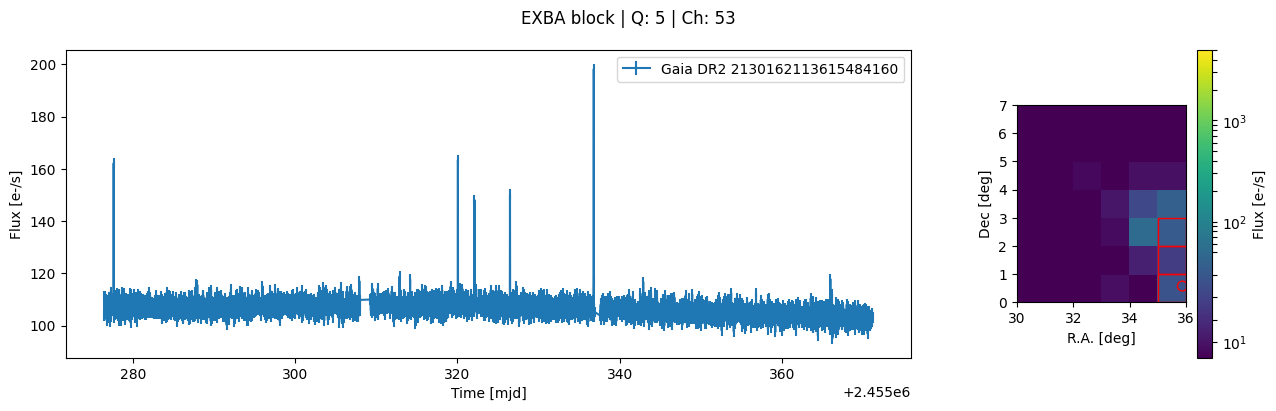

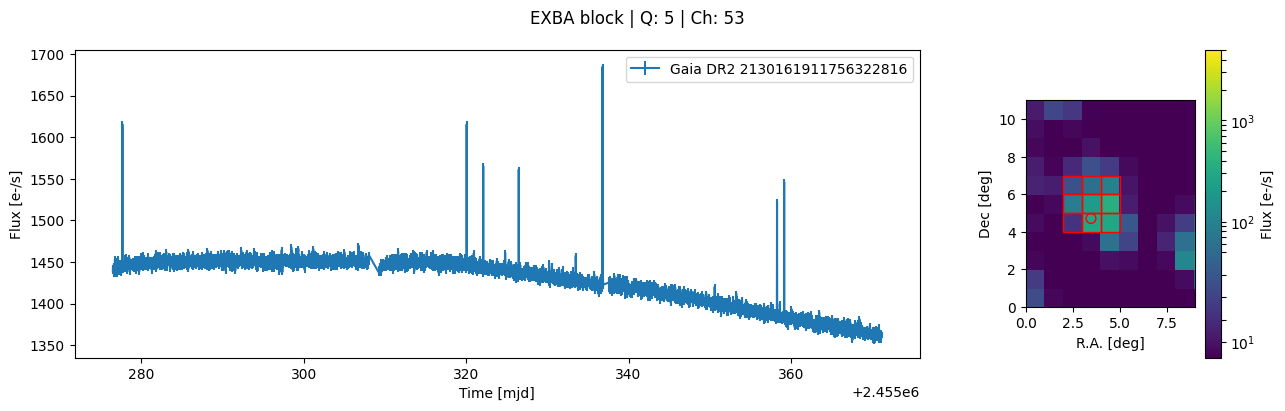

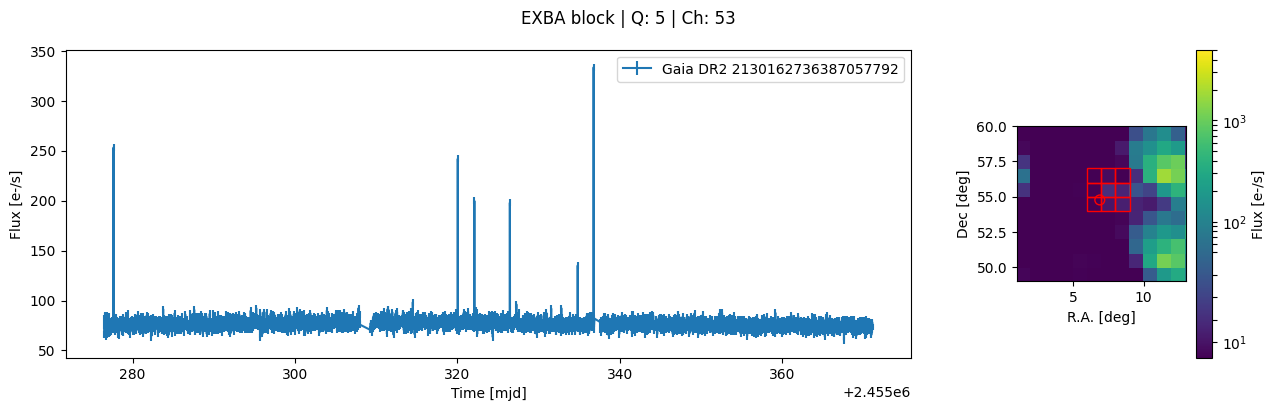

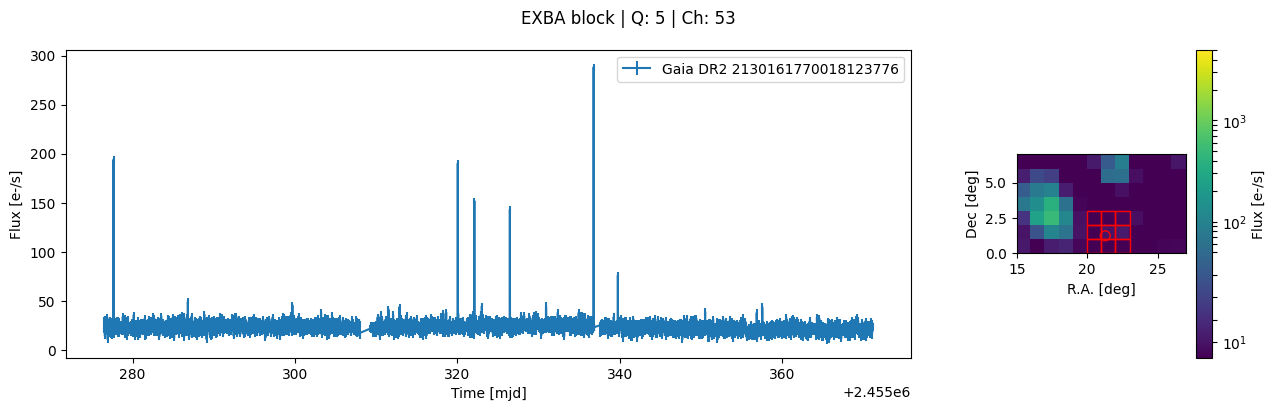

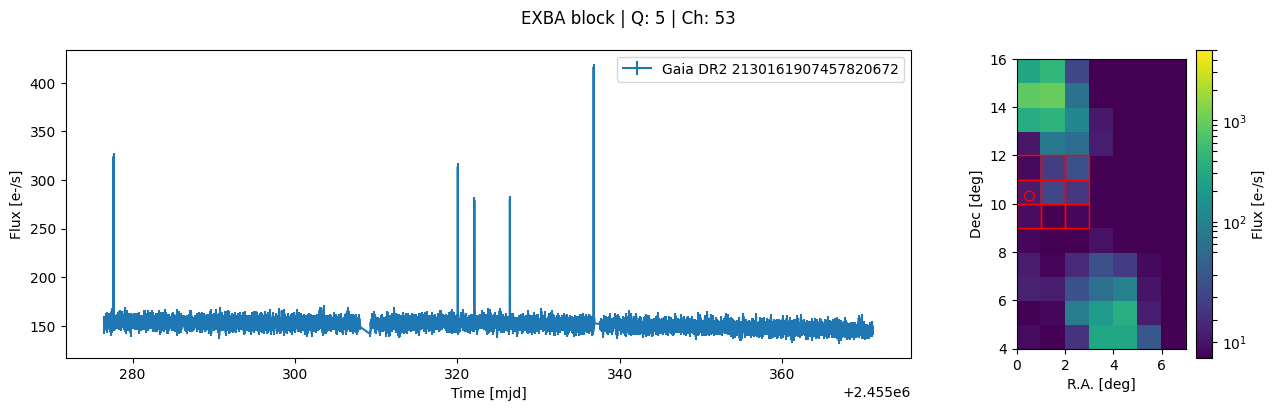

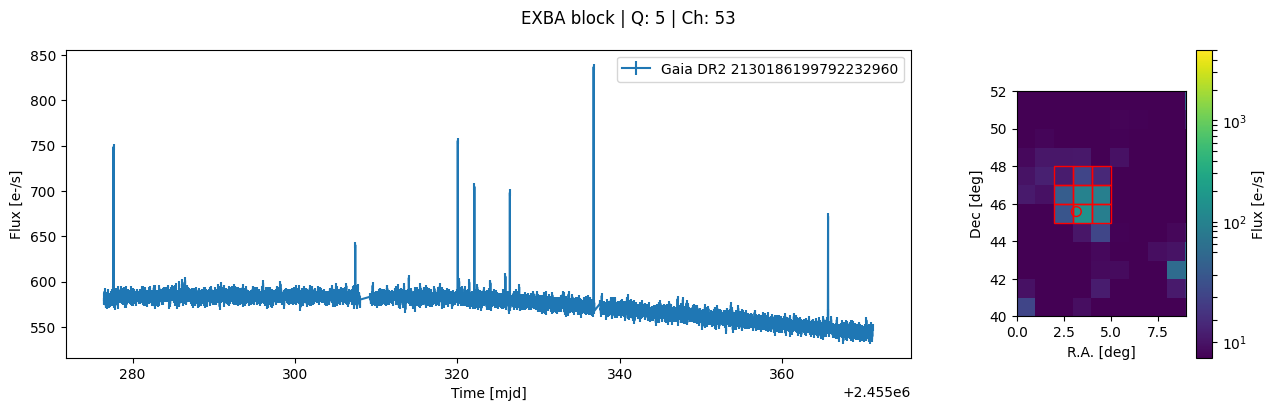

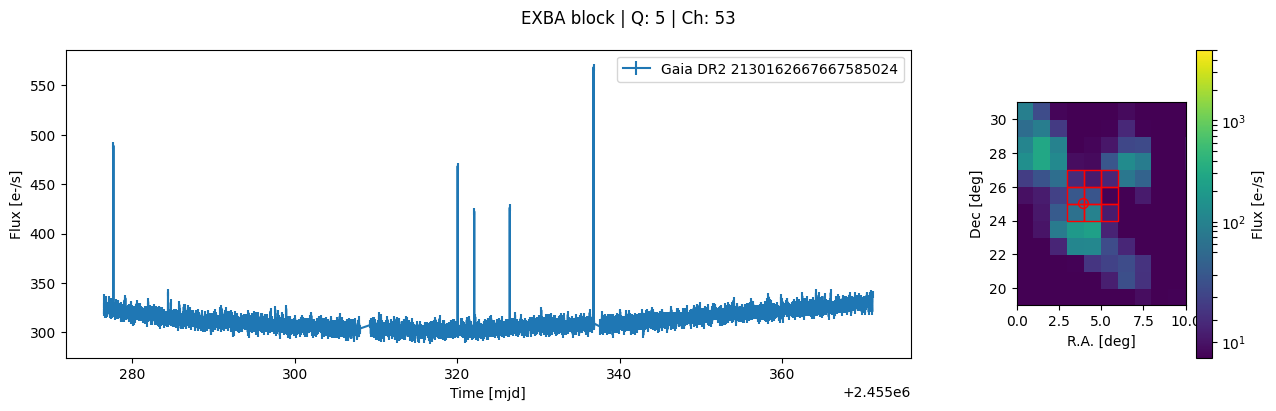

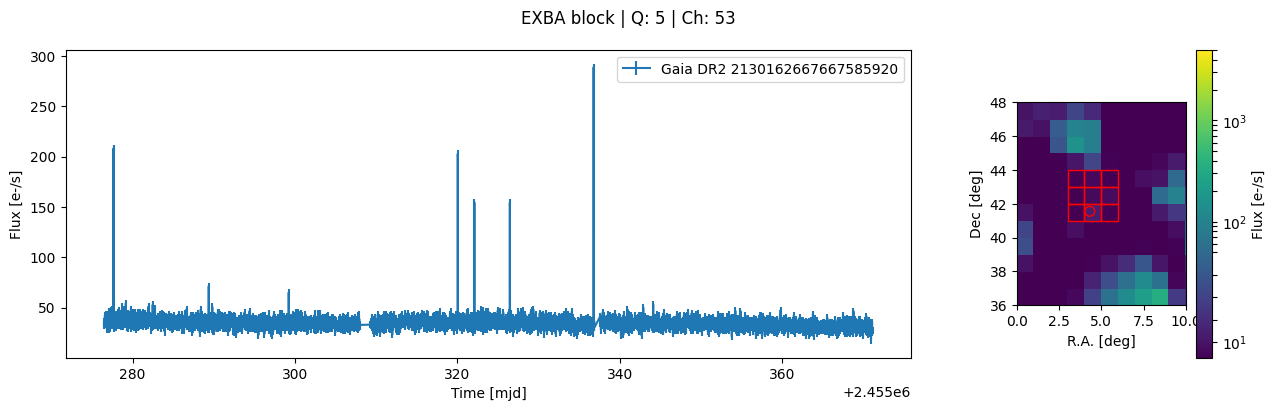

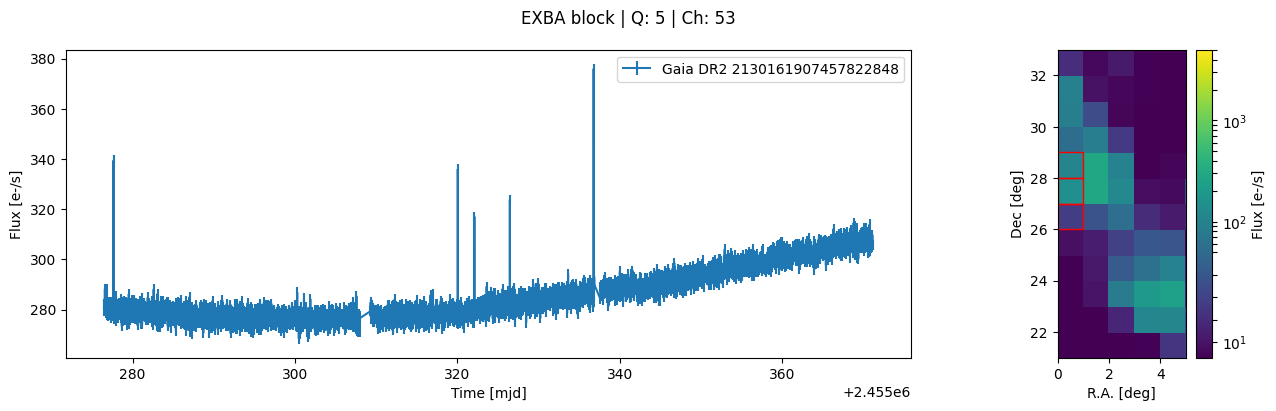

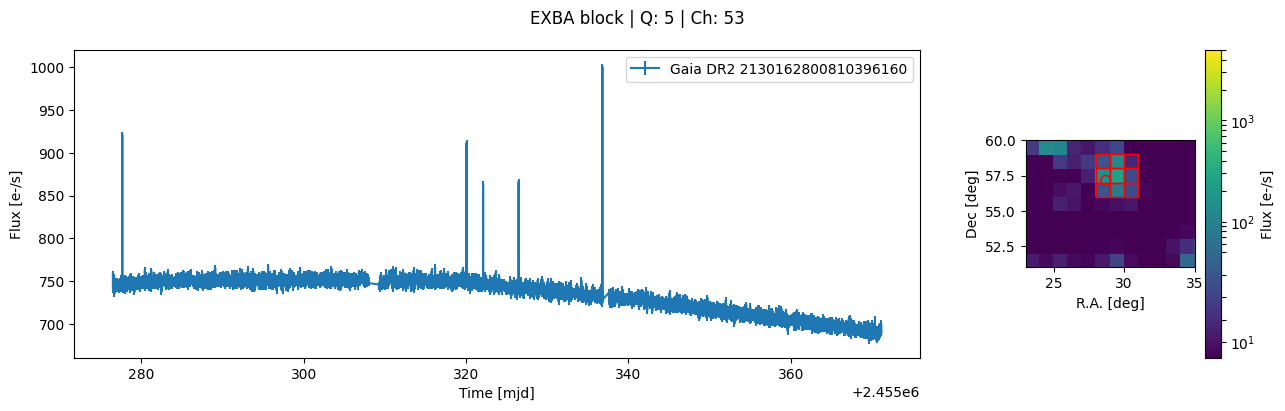

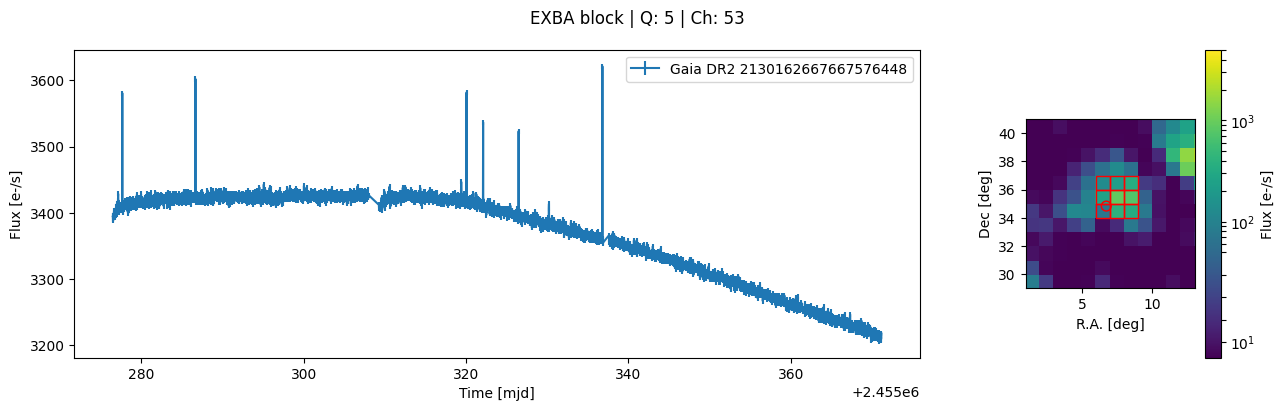

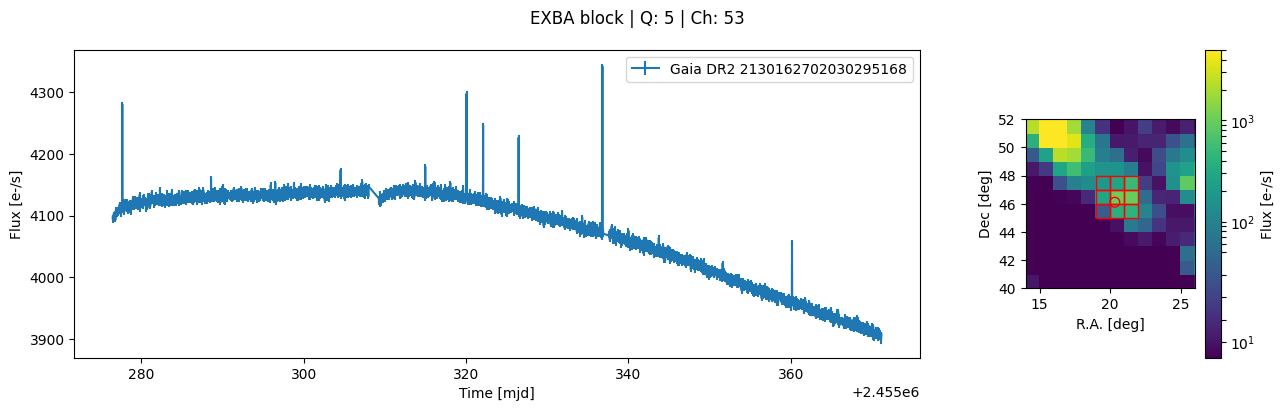

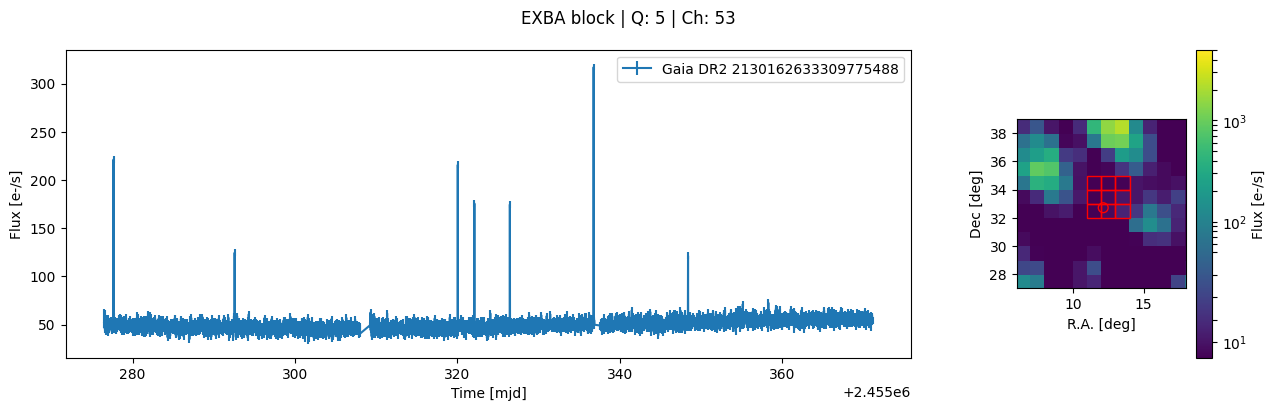

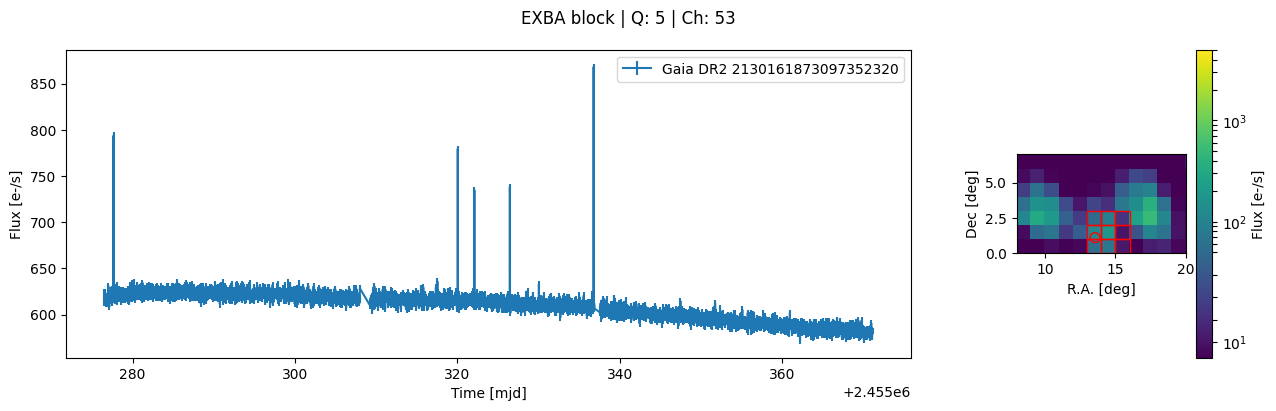

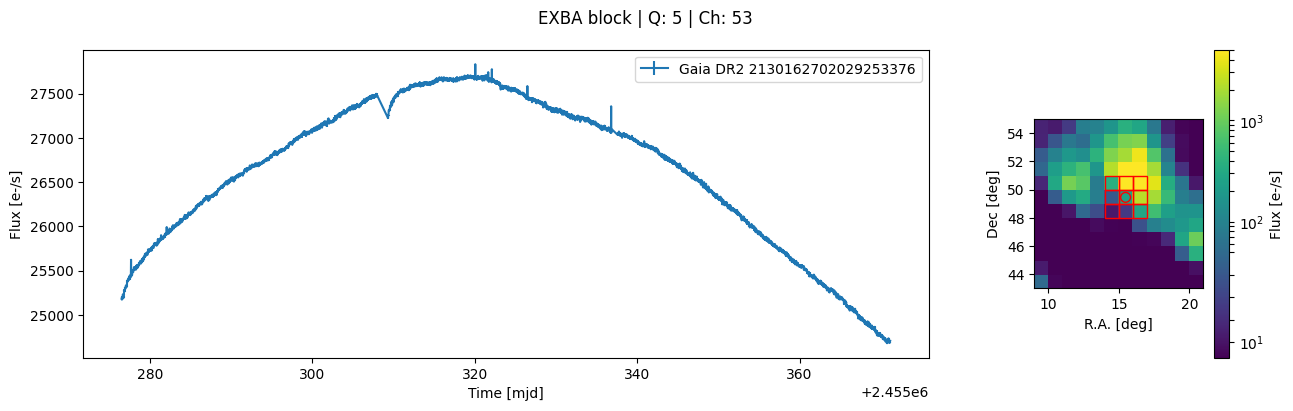

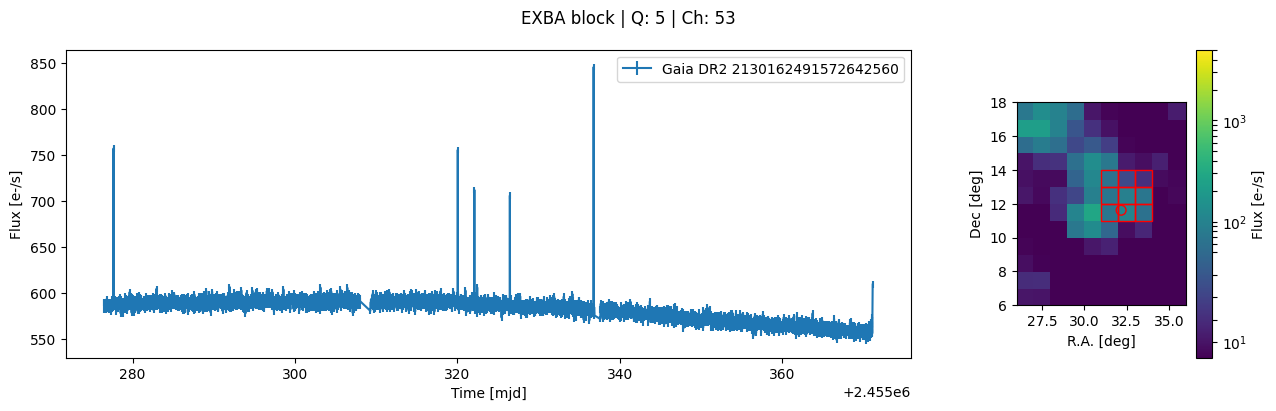

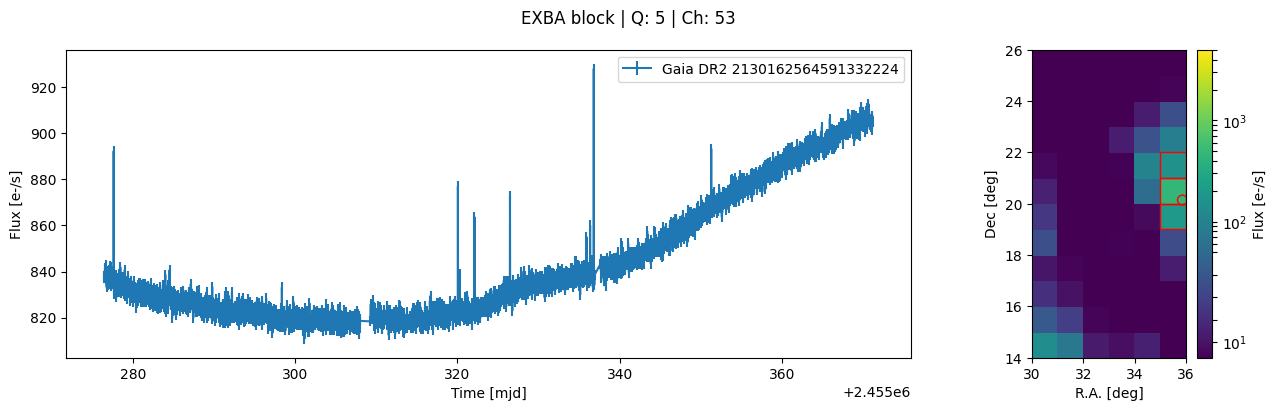

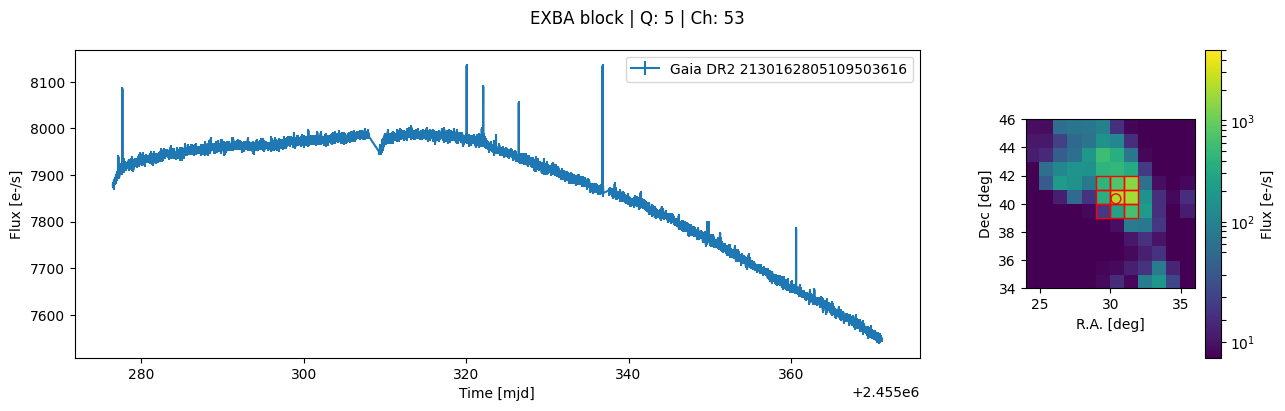

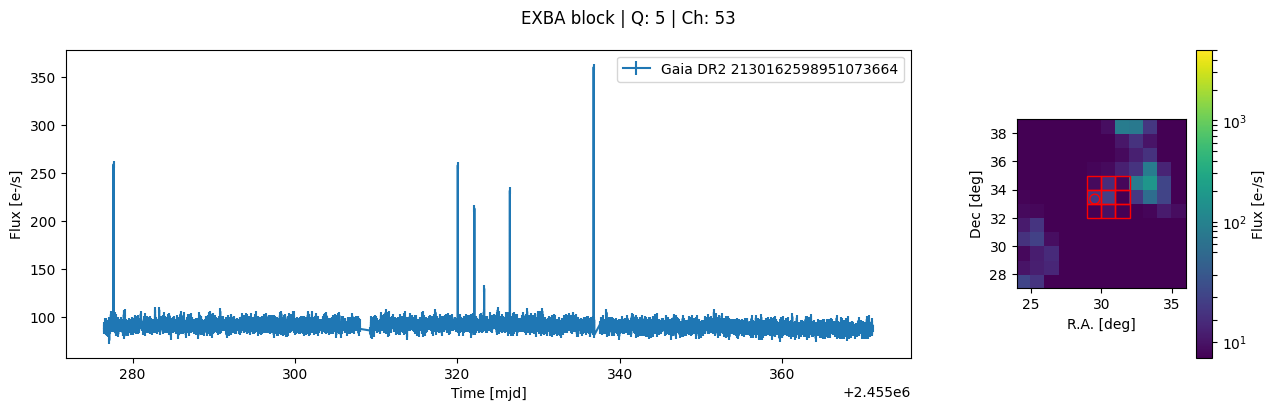

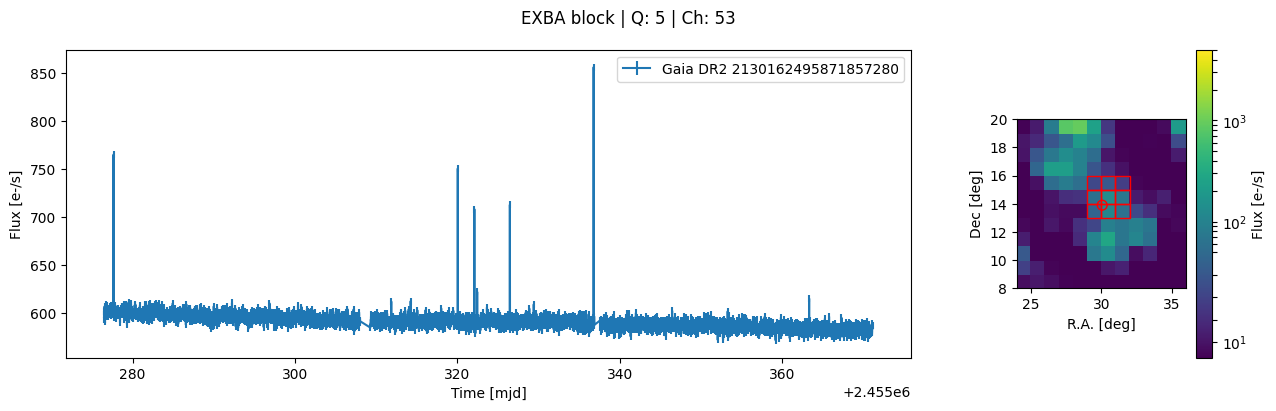

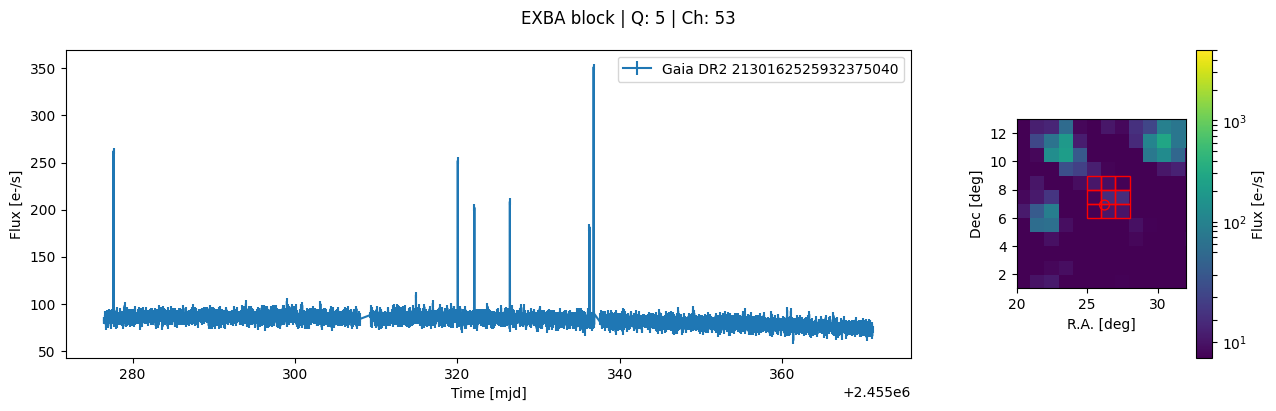

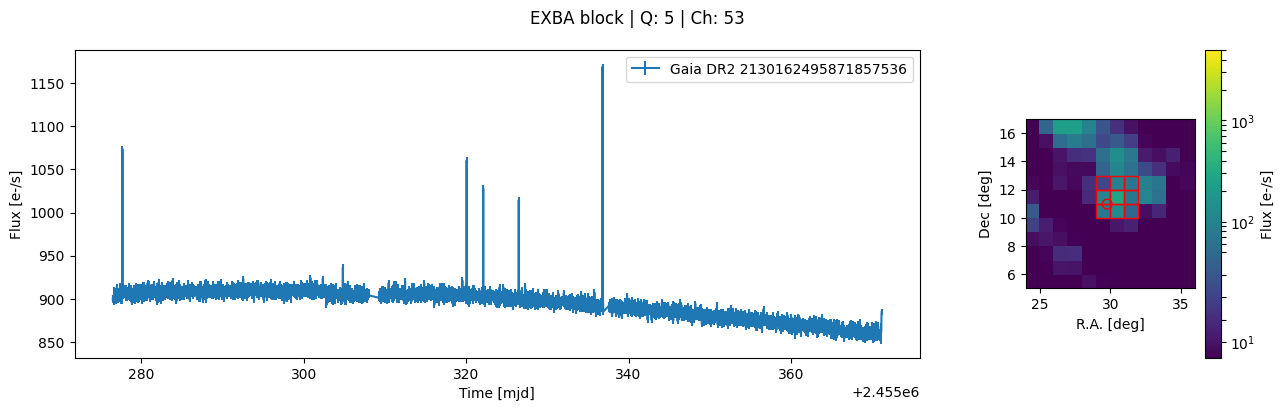

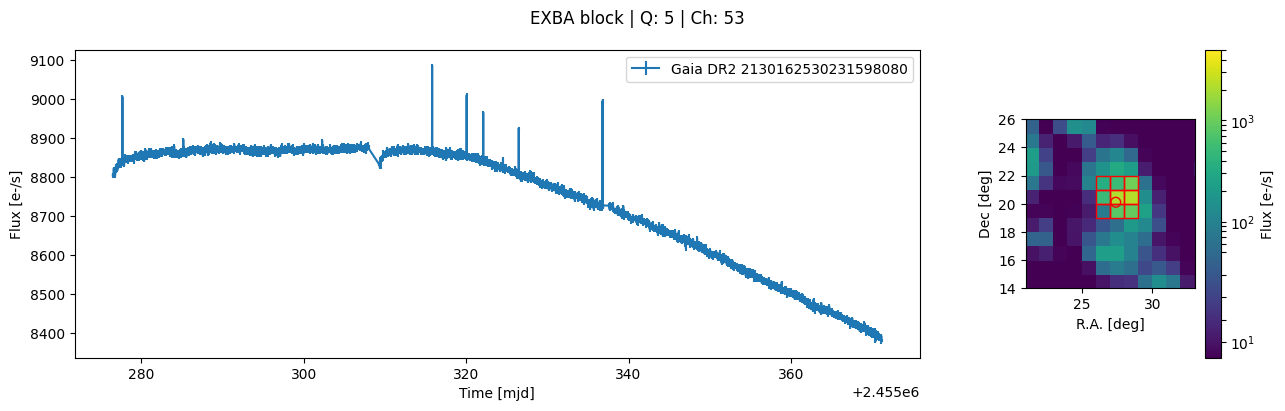

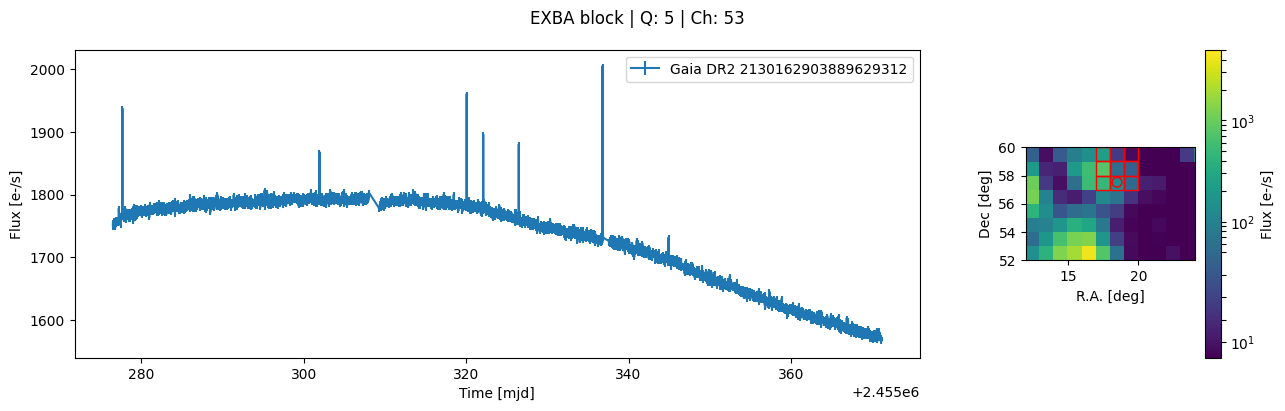

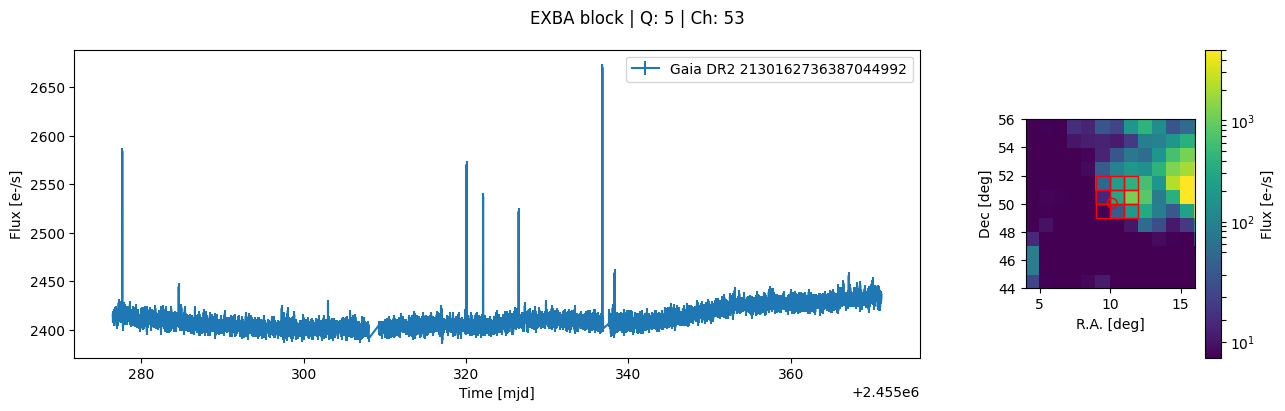

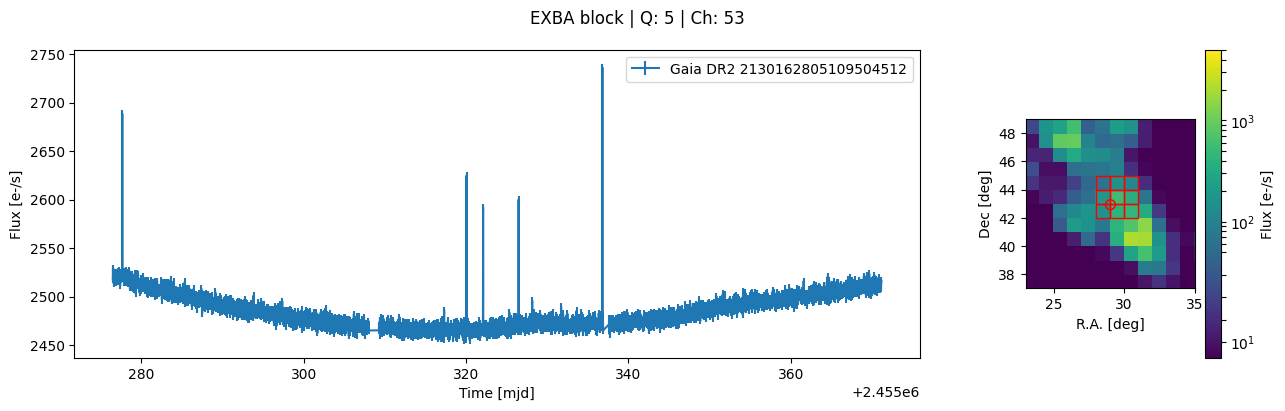

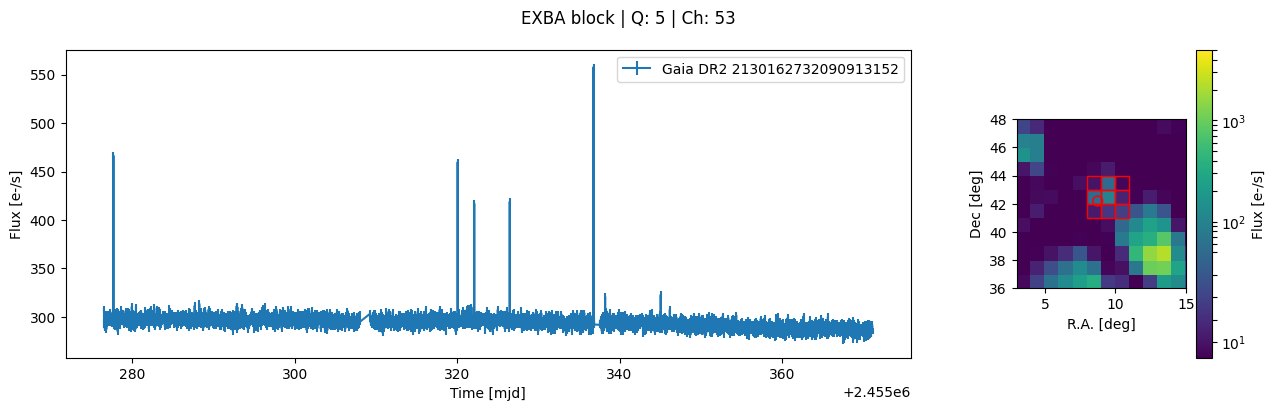

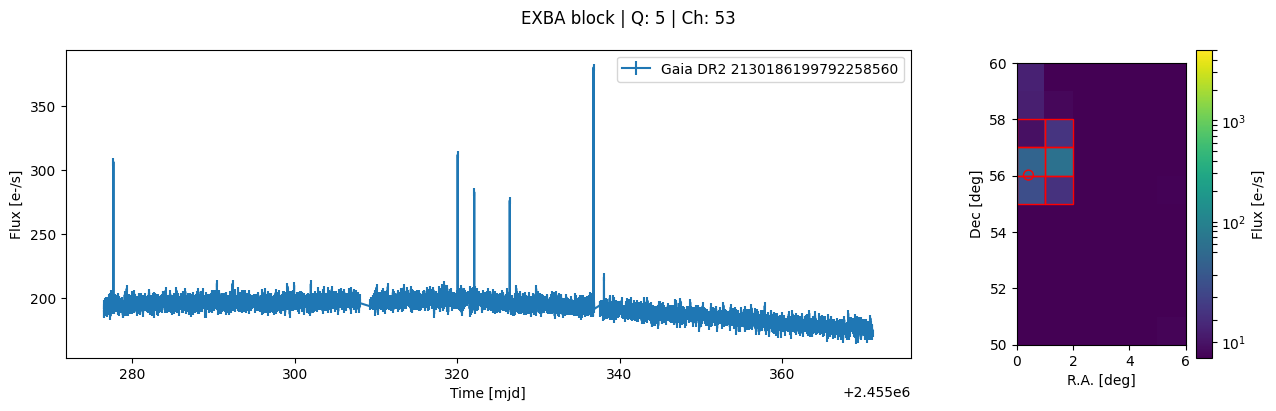

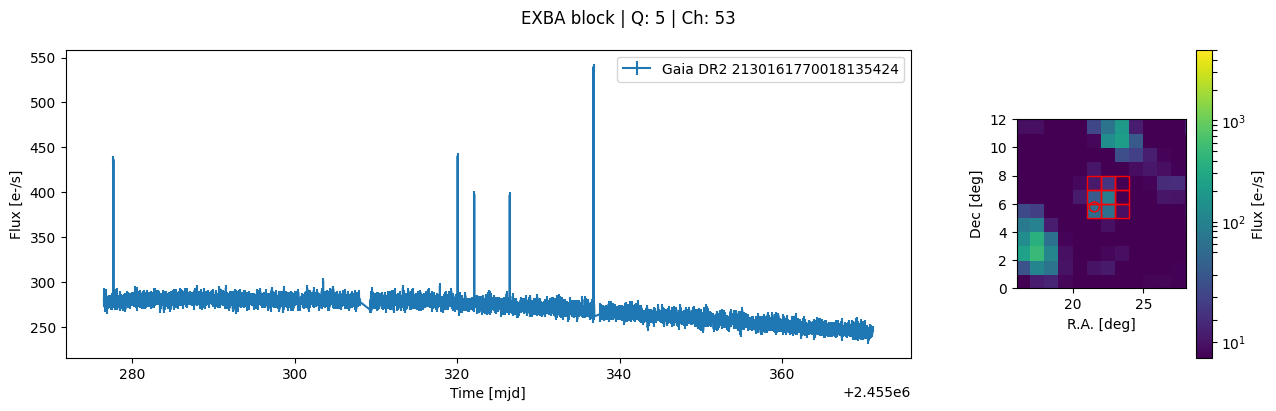

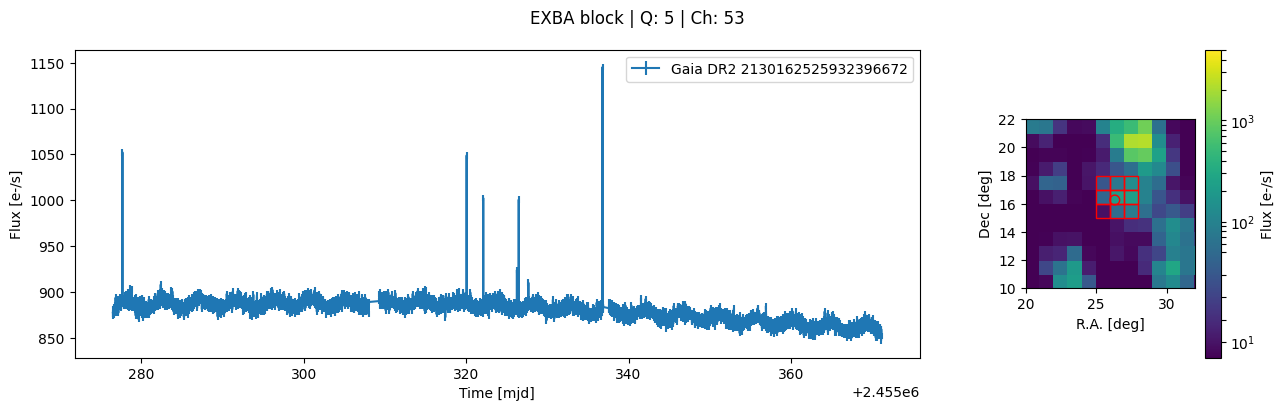

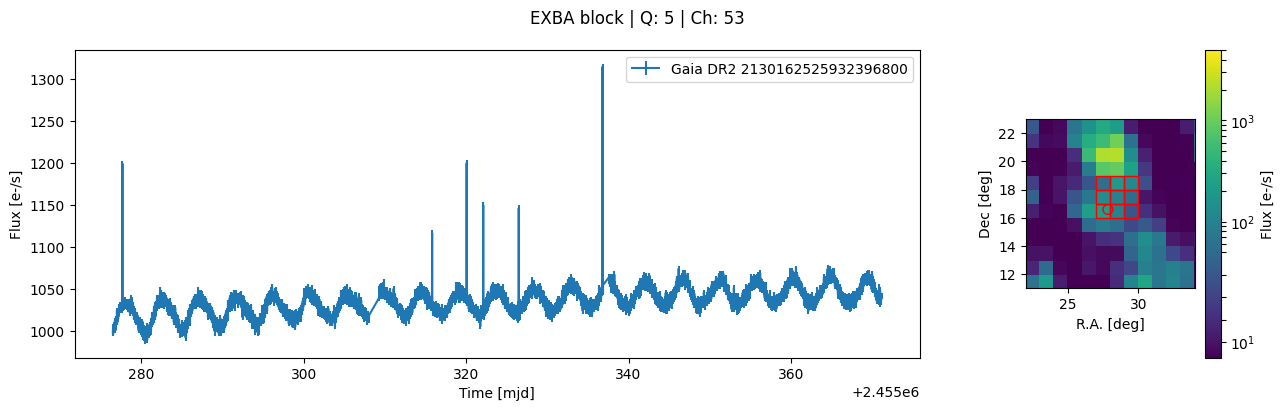

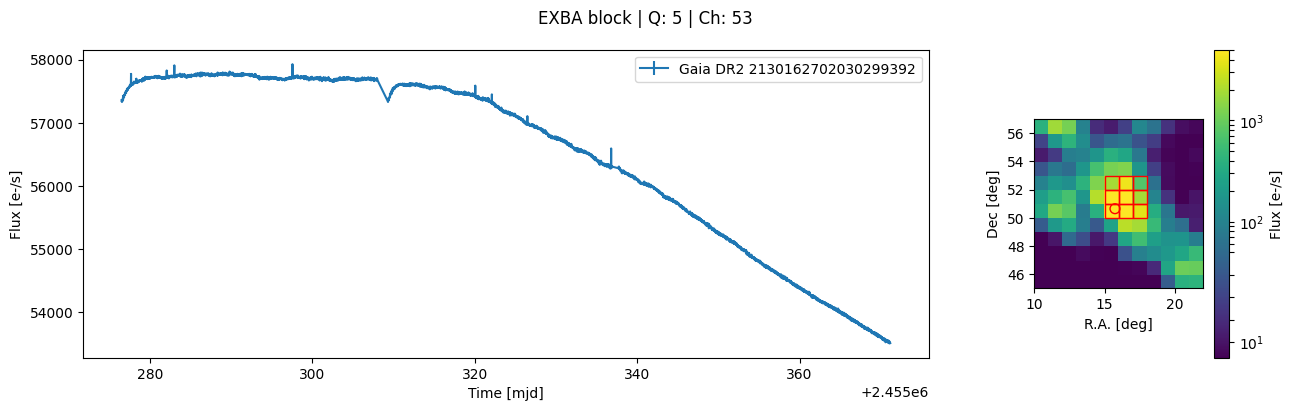

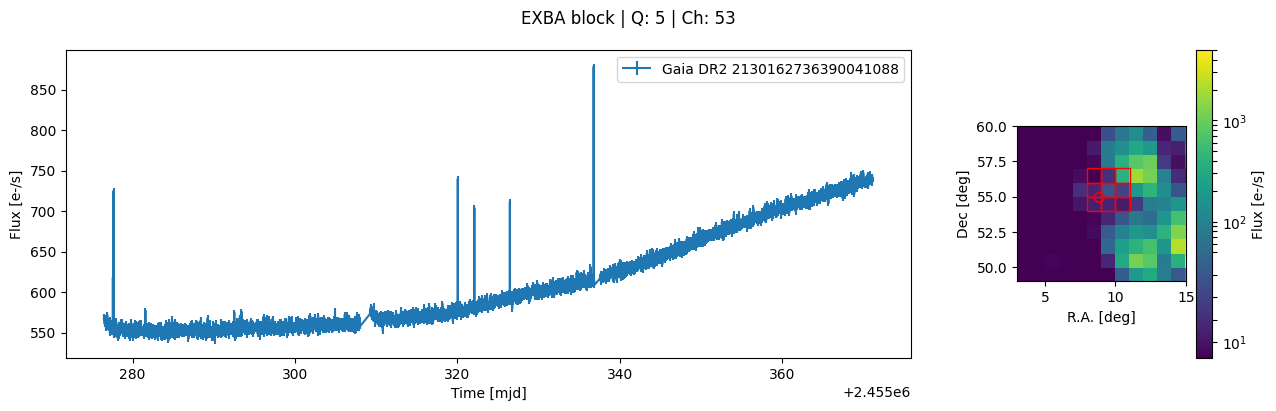

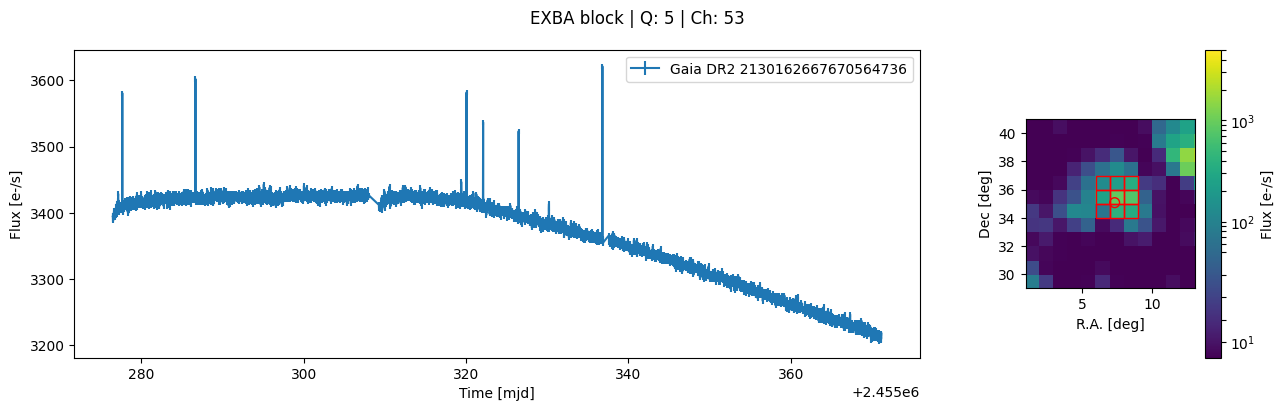

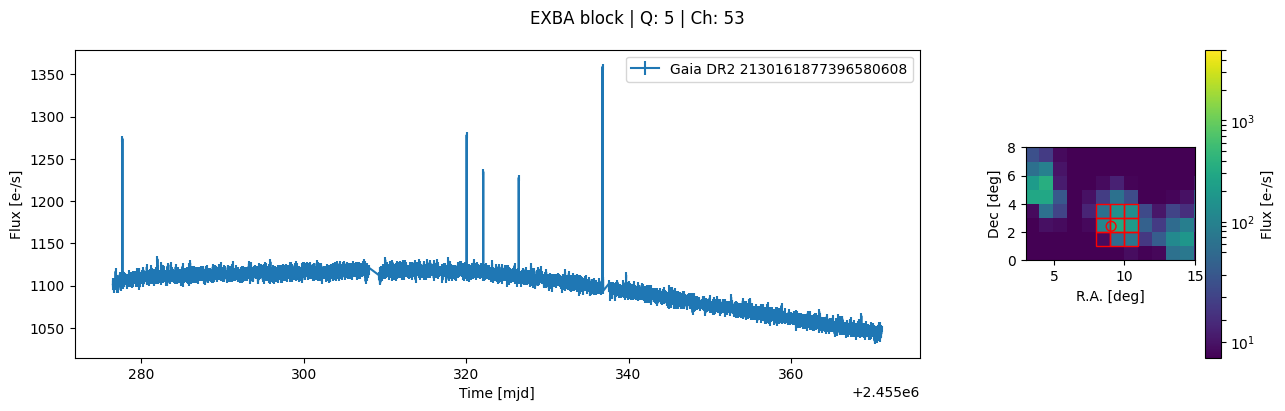

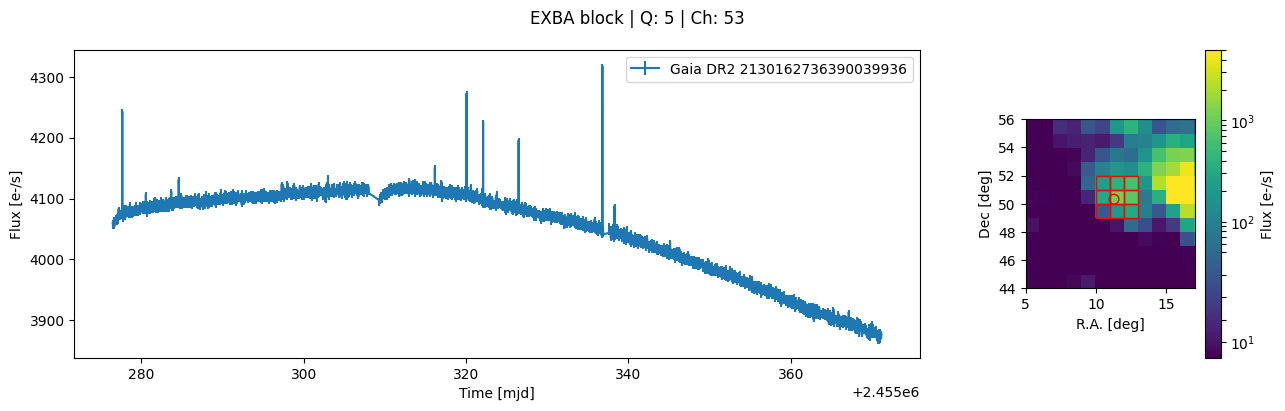

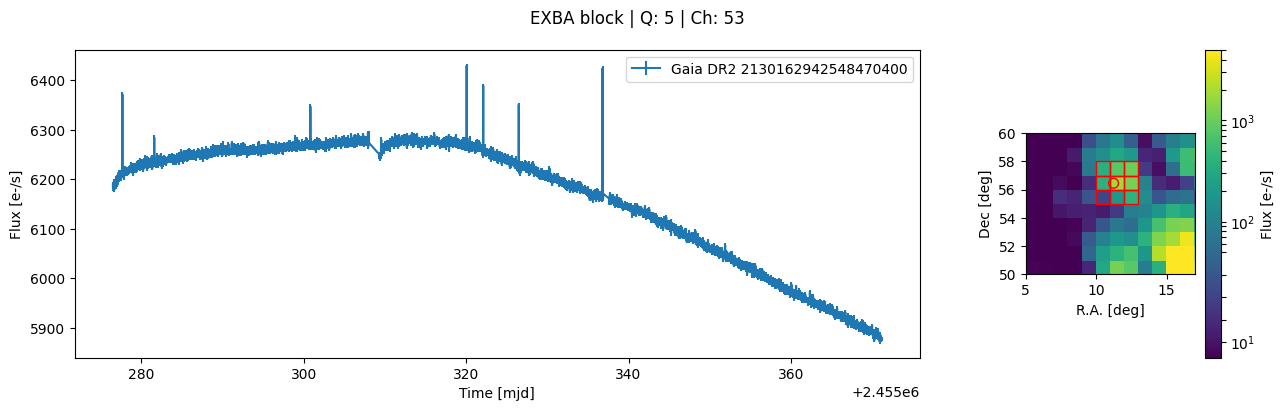

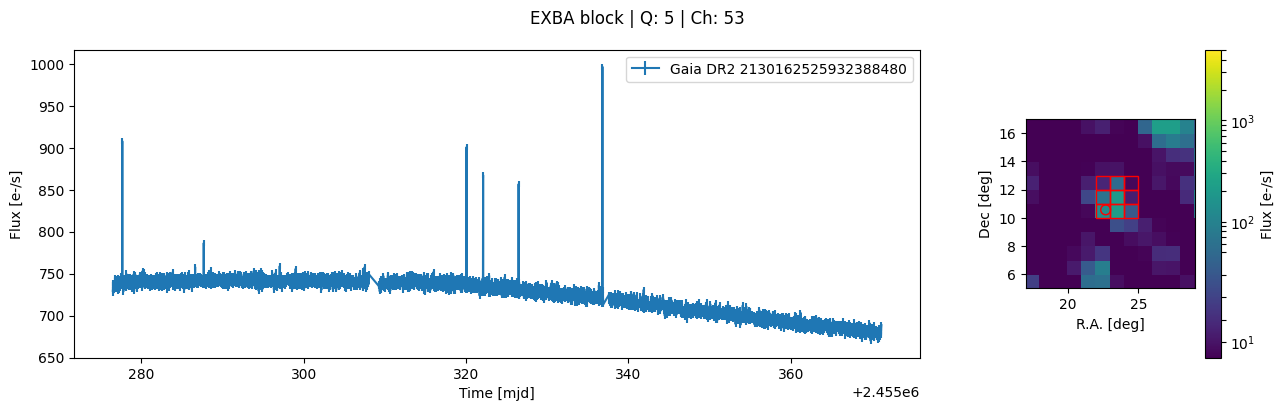

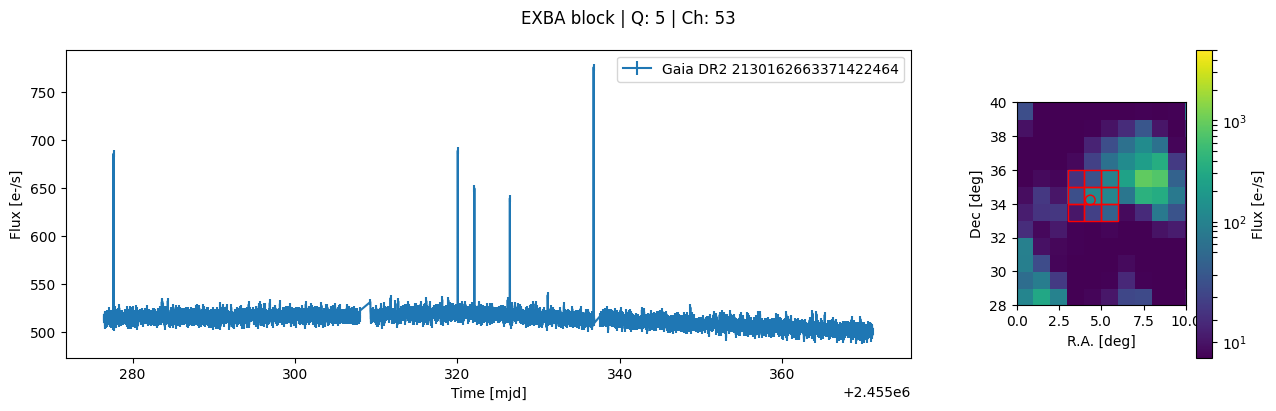

In [134]:
for s in range(0, len(sources)):
    if ap_mask[s].sum() == 0: continue
    fig, ax = plt.subplots(1, 2, figsize=(15,4), gridspec_kw={'width_ratios': [4, 1]})

    ax[0].errorbar(times, sap[s], yerr=sap_err[s], label=sources.designation[s])
    ax[0].legend(loc='upper right')
    ax[0].set_xlabel('Time [mjd]')
    ax[0].set_ylabel('Flux [e-/s]')

    fig.suptitle('EXBA block | Q: %i | Ch: %i' % (tpfs[0].get_header()["QUARTER"],
                                                  tpfs[0].get_header()["CHANNEL"]))
    pc = ax[1].pcolor(flux[1000], shading='auto',
                       norm=colors.SymLogNorm(linthresh=50, vmin=3, vmax=5000, base=10))
    ax[1].scatter(sources.col[s], sources.row[s], s=50, facecolors='none', 
               marker='o', edgecolors='r')
    ax[1].set_xlabel('R.A. [deg]')
    ax[1].set_ylabel('Dec [deg]')
    fig.colorbar(pc, label='Flux [e-/s]')
    ax[1].set_aspect('equal', adjustable='box')

    for i in range(ra.shape[0]):
        for j in range(ra.shape[1]):
            if ap_mask[s, i, j]:
                rect = patches.Rectangle(
                                xy=(j, i),
                                width=1, height=1, color='red',
                                fill=False, hatch='')
                ax[1].add_patch(rect)
    zoom = np.argwhere(ap_mask[s] == True)
    ax[1].set_ylim(np.maximum(0, zoom[0,0] - 5), np.minimum(zoom[-1,0] + 5, ra.shape[0]))
    ax[1].set_xlim(np.maximum(0, zoom[0,-1] - 5), np.minimum(zoom[-1,-1] + 5, ra.shape[1]))

    plt.show()

# Check lightcurves against SAP_FLUX from near TPFs

In [120]:
tpfs[0].get_header()

SIMPLE  =                    T / conforms to FITS standards                     
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T / file contains extensions                       
NEXTEND =                    2 / number of standard extensions                  
EXTNAME = 'PRIMARY '           / name of extension                              
EXTVER  =                    1 / extension version number (not format version)  
ORIGIN  = 'NASA/Ames'          / institution responsible for creating this file 
DATE    = '2015-09-18'         / file creation date.                            
CREATOR = '885387 TargetPixelExporterPipelineModule' / pipeline job and program 
PROCVER = 'svn+ssh://murzim/repo/soc/tags/release/9.3.23 r60353' / SW version   
FILEVER = '6.1     '           / file format version                            
TIMVERSN= 'OGIP/93-003'     

In [122]:
near_TPFs = lk.search_targetpixelfile(target=target_ids[0], radius=1000, limit=100,
                                      cadence='long', 
                                      mission='Kepler', quarter=5).download_all()

In [123]:
near_TPFs

TargetPixelFileCollection of 100 objects:
	12060431 (1 KeplerTargetPixelFiles) Quarters: 5
	12060455 (1 KeplerTargetPixelFiles) Quarters: 5
	12060458 (1 KeplerTargetPixelFiles) Quarters: 5
	12060564 (1 KeplerTargetPixelFiles) Quarters: 5
	12060710 (1 KeplerTargetPixelFiles) Quarters: 5
	12109402 (1 KeplerTargetPixelFiles) Quarters: 5
	12109421 (1 KeplerTargetPixelFiles) Quarters: 5
	12109430 (1 KeplerTargetPixelFiles) Quarters: 5
	12109442 (1 KeplerTargetPixelFiles) Quarters: 5
	12109449 (1 KeplerTargetPixelFiles) Quarters: 5
	12109451 (1 KeplerTargetPixelFiles) Quarters: 5
	12109472 (1 KeplerTargetPixelFiles) Quarters: 5
	12109479 (1 KeplerTargetPixelFiles) Quarters: 5
	12109480 (1 KeplerTargetPixelFiles) Quarters: 5
	12109540 (1 KeplerTargetPixelFiles) Quarters: 5
	12109547 (1 KeplerTargetPixelFiles) Quarters: 5
	12109550 (1 KeplerTargetPixelFiles) Quarters: 5
	12109560 (1 KeplerTargetPixelFiles) Quarters: 5
	12109575 (1 KeplerTargetPixelFiles) Quarters: 5
	12109594 (1 KeplerTargetPi